In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size)
        Qlogits = tf.layers.dense(inputs=states_logits, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size,
               states, actions, next_states, dones, rates):
    ################################################ s', r = env(s, a)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=states.dtype)
    e_next_states_logits, eQlogits = Env(actions=actions_labels, states=states, hidden_size=hidden_size,
                                         action_size=action_size, state_size=state_size)
    ################################################ a = act(s)
    ################################################ s', r = env(s, a)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    a_next_states_logits, aQlogits = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                         action_size=action_size, state_size=state_size, reuse=True)
    ###############################################
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                                 labels=next_states_labels), 
                                         axis=1))
    eloss += -tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                                   labels=next_states_labels), 
                                           axis=1))
    aloss = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                                 labels=next_states_labels), 
                                          axis=1))
    #################################################### MC Qlearning
    eQlogits = tf.reshape(eQlogits, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQlogits, labels=rates))
    ################################################ a' = act(s')
    ################################################ s', Q' = env(s', a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, nextQlogits = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                         action_size=action_size, state_size=state_size, reuse=True)
    nextQlogits = tf.reshape(nextQlogits, shape=[-1]) * (1- dones)
    eloss += tf.reduce_mean(tf.square(eQlogits - nextQlogits))
    ################################################ a = act(s)
    aQlogits = tf.reshape(aQlogits, shape=[-1])
    aloss += tf.reduce_mean(aQlogits)
    return actions_logits, aloss, eloss

In [7]:
def model_opt(a_loss, e_loss, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
    return a_opt, e_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size,
            states=self.states, actions=self.actions, next_states=self.next_states, dones=self.dones, 
            rates=self.rates)
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt = model_opt(a_loss=self.a_loss, e_loss=self.e_loss,
                                           a_learning_rate=a_learning_rate,
                                           e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
rate = -1
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset
        rate = -1 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [15]:
def minibacth_random(memory, batch_size):
    while True:
        batch = memory.sample(batch_size=batch_size)
        rates = np.array([each[5] for each in batch])
        states = np.array([each[0] for each in batch])[rates > 0]
        actions = np.array([each[1] for each in batch])[rates > 0]
        next_states = np.array([each[2] for each in batch])[rates > 0]
        rewards = np.array([each[3] for each in batch])[rates > 0]
        dones = np.array([each[4] for each in batch])[rates > 0]
        rates = np.array([each[5] for each in batch])[rates > 0]
        if len(dones) > 1:
            break
    return states, actions, next_states, rewards, dones, rates

In [16]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch = [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth_random(memory=memory, 
                                                                                   batch_size=batch_size)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:15.0000 R:15.0000 rate:0.0300 aloss:2.7436 eloss:0.6976 exploreP:0.9985
Episode:1 meanR:18.5000 R:22.0000 rate:0.0440 aloss:2.7334 eloss:0.6915 exploreP:0.9963
Episode:2 meanR:24.6667 R:37.0000 rate:0.0740 aloss:2.7107 eloss:0.6825 exploreP:0.9927
Episode:3 meanR:22.5000 R:16.0000 rate:0.0320 aloss:2.6880 eloss:0.6727 exploreP:0.9911
Episode:4 meanR:21.2000 R:16.0000 rate:0.0320 aloss:2.6733 eloss:0.6670 exploreP:0.9896
Episode:5 meanR:20.6667 R:18.0000 rate:0.0360 aloss:2.6570 eloss:0.6612 exploreP:0.9878
Episode:6 meanR:20.5714 R:20.0000 rate:0.0400 aloss:2.6412 eloss:0.6539 exploreP:0.9858
Episode:7 meanR:19.7500 R:14.0000 rate:0.0280 aloss:2.6210 eloss:0.6469 exploreP:0.9845
Episode:8 meanR:21.2222 R:33.0000 rate:0.0660 aloss:2.5947 eloss:0.6370 exploreP:0.9813
Episode:9 meanR:22.9000 R:38.0000 rate:0.0760 aloss:2.5520 eloss:0.6215 exploreP:0.9776
Episode:10 meanR:22.5455 R:19.0000 rate:0.0380 aloss:2.5096 eloss:0.6078 exploreP:0.9757
Episode:11 meanR:22.4167 R:21.0

Episode:93 meanR:24.5957 R:20.0000 rate:0.0400 aloss:1.9504 eloss:0.4377 exploreP:0.7956
Episode:94 meanR:24.4737 R:13.0000 rate:0.0260 aloss:1.9511 eloss:0.4284 exploreP:0.7946
Episode:95 meanR:24.4271 R:20.0000 rate:0.0400 aloss:1.9464 eloss:0.4284 exploreP:0.7931
Episode:96 meanR:24.5876 R:40.0000 rate:0.0800 aloss:1.9390 eloss:0.4228 exploreP:0.7899
Episode:97 meanR:24.6735 R:33.0000 rate:0.0660 aloss:1.9324 eloss:0.4096 exploreP:0.7874
Episode:98 meanR:24.6970 R:27.0000 rate:0.0540 aloss:1.9220 eloss:0.4022 exploreP:0.7853
Episode:99 meanR:24.6700 R:22.0000 rate:0.0440 aloss:1.9170 eloss:0.3946 exploreP:0.7836
Episode:100 meanR:24.7200 R:20.0000 rate:0.0400 aloss:1.9105 eloss:0.3870 exploreP:0.7820
Episode:101 meanR:24.9000 R:40.0000 rate:0.0800 aloss:1.9028 eloss:0.3823 exploreP:0.7789
Episode:102 meanR:25.4300 R:90.0000 rate:0.1800 aloss:1.8819 eloss:0.3607 exploreP:0.7720
Episode:103 meanR:25.4400 R:17.0000 rate:0.0340 aloss:1.8690 eloss:0.3446 exploreP:0.7708
Episode:104 meanR

Episode:185 meanR:21.5000 R:14.0000 rate:0.0280 aloss:1.8300 eloss:0.3532 exploreP:0.6615
Episode:186 meanR:21.4500 R:19.0000 rate:0.0380 aloss:1.8267 eloss:0.3596 exploreP:0.6602
Episode:187 meanR:21.5600 R:25.0000 rate:0.0500 aloss:1.8229 eloss:0.3766 exploreP:0.6586
Episode:188 meanR:20.8800 R:16.0000 rate:0.0320 aloss:1.8202 eloss:0.3762 exploreP:0.6576
Episode:189 meanR:20.1800 R:13.0000 rate:0.0260 aloss:1.8303 eloss:0.3712 exploreP:0.6567
Episode:190 meanR:20.1000 R:12.0000 rate:0.0240 aloss:1.8360 eloss:0.3754 exploreP:0.6559
Episode:191 meanR:20.0200 R:10.0000 rate:0.0200 aloss:1.8319 eloss:0.3660 exploreP:0.6553
Episode:192 meanR:19.9900 R:11.0000 rate:0.0220 aloss:1.8338 eloss:0.3672 exploreP:0.6546
Episode:193 meanR:20.0100 R:22.0000 rate:0.0440 aloss:1.8324 eloss:0.3689 exploreP:0.6532
Episode:194 meanR:19.9900 R:11.0000 rate:0.0220 aloss:1.8239 eloss:0.3707 exploreP:0.6525
Episode:195 meanR:19.9300 R:14.0000 rate:0.0280 aloss:1.8294 eloss:0.3712 exploreP:0.6516
Episode:19

Episode:277 meanR:13.8700 R:9.0000 rate:0.0180 aloss:1.8356 eloss:0.2887 exploreP:0.5830
Episode:278 meanR:13.8500 R:11.0000 rate:0.0220 aloss:1.8315 eloss:0.2965 exploreP:0.5823
Episode:279 meanR:13.7700 R:11.0000 rate:0.0220 aloss:1.8154 eloss:0.3005 exploreP:0.5817
Episode:280 meanR:13.8100 R:15.0000 rate:0.0300 aloss:1.8179 eloss:0.2875 exploreP:0.5808
Episode:281 meanR:13.9200 R:23.0000 rate:0.0460 aloss:1.8120 eloss:0.2793 exploreP:0.5795
Episode:282 meanR:13.9300 R:14.0000 rate:0.0280 aloss:1.8026 eloss:0.2748 exploreP:0.5787
Episode:283 meanR:13.9800 R:15.0000 rate:0.0300 aloss:1.8111 eloss:0.2733 exploreP:0.5779
Episode:284 meanR:14.0000 R:13.0000 rate:0.0260 aloss:1.8009 eloss:0.2606 exploreP:0.5771
Episode:285 meanR:13.9500 R:9.0000 rate:0.0180 aloss:1.7925 eloss:0.2645 exploreP:0.5766
Episode:286 meanR:13.8600 R:10.0000 rate:0.0200 aloss:1.7996 eloss:0.2616 exploreP:0.5761
Episode:287 meanR:13.9400 R:33.0000 rate:0.0660 aloss:1.7912 eloss:0.2556 exploreP:0.5742
Episode:288 

Episode:369 meanR:15.2300 R:13.0000 rate:0.0260 aloss:1.8220 eloss:0.3578 exploreP:0.5072
Episode:370 meanR:15.2400 R:13.0000 rate:0.0260 aloss:1.8116 eloss:0.3547 exploreP:0.5066
Episode:371 meanR:15.1200 R:11.0000 rate:0.0220 aloss:1.8154 eloss:0.3549 exploreP:0.5060
Episode:372 meanR:15.0800 R:10.0000 rate:0.0200 aloss:1.8007 eloss:0.3428 exploreP:0.5055
Episode:373 meanR:15.0200 R:8.0000 rate:0.0160 aloss:1.7954 eloss:0.3461 exploreP:0.5051
Episode:374 meanR:15.0300 R:13.0000 rate:0.0260 aloss:1.7956 eloss:0.3421 exploreP:0.5045
Episode:375 meanR:15.0100 R:9.0000 rate:0.0180 aloss:1.7840 eloss:0.3345 exploreP:0.5040
Episode:376 meanR:15.0700 R:16.0000 rate:0.0320 aloss:1.7823 eloss:0.3293 exploreP:0.5032
Episode:377 meanR:15.1500 R:17.0000 rate:0.0340 aloss:1.7726 eloss:0.3180 exploreP:0.5024
Episode:378 meanR:15.2500 R:21.0000 rate:0.0420 aloss:1.7604 eloss:0.3123 exploreP:0.5014
Episode:379 meanR:15.3800 R:24.0000 rate:0.0480 aloss:1.7455 eloss:0.3077 exploreP:0.5002
Episode:380 

Episode:462 meanR:13.2000 R:16.0000 rate:0.0320 aloss:1.8191 eloss:0.3331 exploreP:0.4504
Episode:463 meanR:13.0500 R:9.0000 rate:0.0180 aloss:1.8340 eloss:0.3296 exploreP:0.4500
Episode:464 meanR:13.0700 R:14.0000 rate:0.0280 aloss:1.8265 eloss:0.3219 exploreP:0.4494
Episode:465 meanR:13.0400 R:9.0000 rate:0.0180 aloss:1.8310 eloss:0.3118 exploreP:0.4490
Episode:466 meanR:13.0900 R:15.0000 rate:0.0300 aloss:1.8270 eloss:0.3162 exploreP:0.4483
Episode:467 meanR:13.1000 R:14.0000 rate:0.0280 aloss:1.8272 eloss:0.3066 exploreP:0.4477
Episode:468 meanR:12.9900 R:12.0000 rate:0.0240 aloss:1.8301 eloss:0.3070 exploreP:0.4472
Episode:469 meanR:13.0200 R:16.0000 rate:0.0320 aloss:1.8241 eloss:0.2981 exploreP:0.4465
Episode:470 meanR:13.0400 R:15.0000 rate:0.0300 aloss:1.8289 eloss:0.2909 exploreP:0.4459
Episode:471 meanR:13.0200 R:9.0000 rate:0.0180 aloss:1.8353 eloss:0.2943 exploreP:0.4455
Episode:472 meanR:13.1300 R:21.0000 rate:0.0420 aloss:1.8310 eloss:0.2910 exploreP:0.4445
Episode:473 m

Episode:554 meanR:12.1200 R:17.0000 rate:0.0340 aloss:1.8853 eloss:0.2832 exploreP:0.4043
Episode:555 meanR:12.1200 R:13.0000 rate:0.0260 aloss:1.8853 eloss:0.2751 exploreP:0.4038
Episode:556 meanR:12.1000 R:14.0000 rate:0.0280 aloss:1.8799 eloss:0.2790 exploreP:0.4032
Episode:557 meanR:12.0800 R:13.0000 rate:0.0260 aloss:1.8825 eloss:0.2811 exploreP:0.4027
Episode:558 meanR:12.0600 R:11.0000 rate:0.0220 aloss:1.8756 eloss:0.2795 exploreP:0.4023
Episode:559 meanR:12.0800 R:14.0000 rate:0.0280 aloss:1.8878 eloss:0.2737 exploreP:0.4017
Episode:560 meanR:12.1100 R:13.0000 rate:0.0260 aloss:1.8812 eloss:0.2717 exploreP:0.4012
Episode:561 meanR:12.0900 R:9.0000 rate:0.0180 aloss:1.8861 eloss:0.2774 exploreP:0.4009
Episode:562 meanR:12.0300 R:10.0000 rate:0.0200 aloss:1.8810 eloss:0.2619 exploreP:0.4005
Episode:563 meanR:12.0900 R:15.0000 rate:0.0300 aloss:1.8876 eloss:0.2725 exploreP:0.3999
Episode:564 meanR:12.0800 R:13.0000 rate:0.0260 aloss:1.8920 eloss:0.2765 exploreP:0.3994
Episode:565

Episode:646 meanR:12.0100 R:20.0000 rate:0.0400 aloss:2.0146 eloss:0.1976 exploreP:0.3631
Episode:647 meanR:12.0000 R:10.0000 rate:0.0200 aloss:2.0123 eloss:0.1854 exploreP:0.3627
Episode:648 meanR:12.0300 R:16.0000 rate:0.0320 aloss:2.0128 eloss:0.1917 exploreP:0.3622
Episode:649 meanR:12.0400 R:13.0000 rate:0.0260 aloss:2.0199 eloss:0.1923 exploreP:0.3617
Episode:650 meanR:12.0200 R:10.0000 rate:0.0200 aloss:2.0198 eloss:0.1903 exploreP:0.3614
Episode:651 meanR:12.0000 R:8.0000 rate:0.0160 aloss:2.0157 eloss:0.1874 exploreP:0.3611
Episode:652 meanR:11.9600 R:8.0000 rate:0.0160 aloss:2.0179 eloss:0.1919 exploreP:0.3608
Episode:653 meanR:11.9500 R:9.0000 rate:0.0180 aloss:2.0256 eloss:0.1775 exploreP:0.3605
Episode:654 meanR:11.8800 R:10.0000 rate:0.0200 aloss:2.0251 eloss:0.1797 exploreP:0.3601
Episode:655 meanR:11.8500 R:10.0000 rate:0.0200 aloss:2.0285 eloss:0.1848 exploreP:0.3598
Episode:656 meanR:11.9000 R:19.0000 rate:0.0380 aloss:2.0195 eloss:0.1882 exploreP:0.3591
Episode:657 m

Episode:738 meanR:11.2500 R:14.0000 rate:0.0280 aloss:2.1417 eloss:0.2035 exploreP:0.3286
Episode:739 meanR:11.2200 R:9.0000 rate:0.0180 aloss:2.1582 eloss:0.1866 exploreP:0.3283
Episode:740 meanR:11.2500 R:11.0000 rate:0.0220 aloss:2.1700 eloss:0.1914 exploreP:0.3280
Episode:741 meanR:11.2500 R:9.0000 rate:0.0180 aloss:2.1653 eloss:0.1918 exploreP:0.3277
Episode:742 meanR:11.2700 R:14.0000 rate:0.0280 aloss:2.1871 eloss:0.1789 exploreP:0.3272
Episode:743 meanR:11.2500 R:8.0000 rate:0.0160 aloss:2.2130 eloss:0.1683 exploreP:0.3270
Episode:744 meanR:11.2200 R:14.0000 rate:0.0280 aloss:2.2069 eloss:0.1615 exploreP:0.3265
Episode:745 meanR:11.2900 R:16.0000 rate:0.0320 aloss:2.2209 eloss:0.1676 exploreP:0.3260
Episode:746 meanR:11.2200 R:13.0000 rate:0.0260 aloss:2.2415 eloss:0.1581 exploreP:0.3256
Episode:747 meanR:11.2700 R:15.0000 rate:0.0300 aloss:2.2434 eloss:0.1404 exploreP:0.3251
Episode:748 meanR:11.2400 R:13.0000 rate:0.0260 aloss:2.2474 eloss:0.1519 exploreP:0.3247
Episode:749 m

Episode:831 meanR:11.2700 R:8.0000 rate:0.0160 aloss:2.3096 eloss:0.4112 exploreP:0.2969
Episode:832 meanR:11.2500 R:9.0000 rate:0.0180 aloss:2.2941 eloss:0.4345 exploreP:0.2967
Episode:833 meanR:11.2500 R:10.0000 rate:0.0200 aloss:2.2785 eloss:0.4720 exploreP:0.2964
Episode:834 meanR:11.2400 R:12.0000 rate:0.0240 aloss:2.2656 eloss:0.4856 exploreP:0.2960
Episode:835 meanR:11.2100 R:9.0000 rate:0.0180 aloss:2.2468 eloss:0.5123 exploreP:0.2958
Episode:836 meanR:11.2200 R:11.0000 rate:0.0220 aloss:2.2337 eloss:0.5469 exploreP:0.2955
Episode:837 meanR:11.2300 R:11.0000 rate:0.0220 aloss:2.2095 eloss:0.5801 exploreP:0.2951
Episode:838 meanR:11.1800 R:9.0000 rate:0.0180 aloss:2.1950 eloss:0.6129 exploreP:0.2949
Episode:839 meanR:11.2400 R:15.0000 rate:0.0300 aloss:2.1788 eloss:0.6252 exploreP:0.2945
Episode:840 meanR:11.2300 R:10.0000 rate:0.0200 aloss:2.1577 eloss:0.6605 exploreP:0.2942
Episode:841 meanR:11.2300 R:9.0000 rate:0.0180 aloss:2.1498 eloss:0.6645 exploreP:0.2939
Episode:842 mea

Episode:924 meanR:10.7800 R:11.0000 rate:0.0220 aloss:2.1744 eloss:0.1433 exploreP:0.2694
Episode:925 meanR:10.7700 R:10.0000 rate:0.0200 aloss:2.1655 eloss:0.1450 exploreP:0.2691
Episode:926 meanR:10.8100 R:15.0000 rate:0.0300 aloss:2.1788 eloss:0.1514 exploreP:0.2687
Episode:927 meanR:10.8100 R:10.0000 rate:0.0200 aloss:2.1823 eloss:0.1627 exploreP:0.2685
Episode:928 meanR:10.8200 R:11.0000 rate:0.0220 aloss:2.1617 eloss:0.1596 exploreP:0.2682
Episode:929 meanR:10.8400 R:11.0000 rate:0.0220 aloss:2.1623 eloss:0.1708 exploreP:0.2679
Episode:930 meanR:10.8600 R:11.0000 rate:0.0220 aloss:2.1679 eloss:0.1850 exploreP:0.2676
Episode:931 meanR:10.9500 R:17.0000 rate:0.0340 aloss:2.1616 eloss:0.1965 exploreP:0.2672
Episode:932 meanR:10.9900 R:13.0000 rate:0.0260 aloss:2.1653 eloss:0.2117 exploreP:0.2668
Episode:933 meanR:11.0200 R:13.0000 rate:0.0260 aloss:2.1498 eloss:0.2206 exploreP:0.2665
Episode:934 meanR:11.0600 R:16.0000 rate:0.0320 aloss:2.1430 eloss:0.2308 exploreP:0.2661
Episode:93

Episode:1016 meanR:13.9100 R:10.0000 rate:0.0200 aloss:2.1242 eloss:0.1090 exploreP:0.2377
Episode:1017 meanR:13.8700 R:9.0000 rate:0.0180 aloss:2.1136 eloss:0.1121 exploreP:0.2375
Episode:1018 meanR:13.8700 R:11.0000 rate:0.0220 aloss:2.1222 eloss:0.1063 exploreP:0.2372
Episode:1019 meanR:14.2700 R:54.0000 rate:0.1080 aloss:2.1266 eloss:0.1261 exploreP:0.2360
Episode:1020 meanR:14.7700 R:61.0000 rate:0.1220 aloss:2.1130 eloss:0.1923 exploreP:0.2346
Episode:1021 meanR:15.1700 R:49.0000 rate:0.0980 aloss:2.0809 eloss:0.2824 exploreP:0.2335
Episode:1022 meanR:15.2100 R:14.0000 rate:0.0280 aloss:2.0684 eloss:0.3028 exploreP:0.2332
Episode:1023 meanR:15.3300 R:21.0000 rate:0.0420 aloss:2.0638 eloss:0.3125 exploreP:0.2327
Episode:1024 meanR:15.3500 R:13.0000 rate:0.0260 aloss:2.0596 eloss:0.3249 exploreP:0.2325
Episode:1025 meanR:15.3700 R:12.0000 rate:0.0240 aloss:2.0603 eloss:0.3224 exploreP:0.2322
Episode:1026 meanR:15.3400 R:12.0000 rate:0.0240 aloss:2.0606 eloss:0.3273 exploreP:0.2319


Episode:1107 meanR:14.3800 R:13.0000 rate:0.0260 aloss:2.0181 eloss:0.1749 exploreP:0.2092
Episode:1108 meanR:14.4200 R:13.0000 rate:0.0260 aloss:1.9979 eloss:0.2017 exploreP:0.2089
Episode:1109 meanR:14.4100 R:11.0000 rate:0.0220 aloss:1.9966 eloss:0.2286 exploreP:0.2087
Episode:1110 meanR:14.3700 R:8.0000 rate:0.0160 aloss:1.9866 eloss:0.2387 exploreP:0.2085
Episode:1111 meanR:14.3700 R:10.0000 rate:0.0200 aloss:1.9839 eloss:0.2399 exploreP:0.2083
Episode:1112 meanR:14.3600 R:11.0000 rate:0.0220 aloss:1.9732 eloss:0.2583 exploreP:0.2081
Episode:1113 meanR:14.4000 R:14.0000 rate:0.0280 aloss:1.9629 eloss:0.2698 exploreP:0.2078
Episode:1114 meanR:14.3200 R:9.0000 rate:0.0180 aloss:1.9420 eloss:0.2847 exploreP:0.2077
Episode:1115 meanR:14.3400 R:11.0000 rate:0.0220 aloss:1.9429 eloss:0.2915 exploreP:0.2075
Episode:1116 meanR:14.3500 R:11.0000 rate:0.0220 aloss:1.9284 eloss:0.2987 exploreP:0.2072
Episode:1117 meanR:14.3600 R:10.0000 rate:0.0200 aloss:1.9265 eloss:0.2987 exploreP:0.2070
E

Episode:1198 meanR:12.2300 R:10.0000 rate:0.0200 aloss:2.2587 eloss:0.1278 exploreP:0.1906
Episode:1199 meanR:12.1500 R:10.0000 rate:0.0200 aloss:2.2581 eloss:0.1258 exploreP:0.1905
Episode:1200 meanR:12.0200 R:10.0000 rate:0.0200 aloss:2.2691 eloss:0.1121 exploreP:0.1903
Episode:1201 meanR:11.8800 R:12.0000 rate:0.0240 aloss:2.2725 eloss:0.1068 exploreP:0.1901
Episode:1202 meanR:11.7700 R:13.0000 rate:0.0260 aloss:2.2964 eloss:0.1064 exploreP:0.1898
Episode:1203 meanR:11.3200 R:9.0000 rate:0.0180 aloss:2.2930 eloss:0.0955 exploreP:0.1897
Episode:1204 meanR:11.0500 R:11.0000 rate:0.0220 aloss:2.3022 eloss:0.1009 exploreP:0.1895
Episode:1205 meanR:10.7400 R:9.0000 rate:0.0180 aloss:2.3129 eloss:0.0878 exploreP:0.1893
Episode:1206 meanR:10.7600 R:12.0000 rate:0.0240 aloss:2.2901 eloss:0.0910 exploreP:0.1891
Episode:1207 meanR:10.7200 R:9.0000 rate:0.0180 aloss:2.3108 eloss:0.0938 exploreP:0.1889
Episode:1208 meanR:10.6900 R:10.0000 rate:0.0200 aloss:2.3180 eloss:0.1200 exploreP:0.1888
Ep

Episode:1289 meanR:10.5000 R:12.0000 rate:0.0240 aloss:2.1070 eloss:0.2483 exploreP:0.1741
Episode:1290 meanR:10.5000 R:10.0000 rate:0.0200 aloss:2.0911 eloss:0.2657 exploreP:0.1740
Episode:1291 meanR:10.5200 R:12.0000 rate:0.0240 aloss:2.0929 eloss:0.2793 exploreP:0.1738
Episode:1292 meanR:10.5200 R:9.0000 rate:0.0180 aloss:2.0798 eloss:0.2778 exploreP:0.1736
Episode:1293 meanR:10.5000 R:9.0000 rate:0.0180 aloss:2.0780 eloss:0.2959 exploreP:0.1735
Episode:1294 meanR:10.5100 R:11.0000 rate:0.0220 aloss:2.0811 eloss:0.2986 exploreP:0.1733
Episode:1295 meanR:10.5100 R:10.0000 rate:0.0200 aloss:2.0791 eloss:0.3069 exploreP:0.1731
Episode:1296 meanR:10.5200 R:12.0000 rate:0.0240 aloss:2.0672 eloss:0.3137 exploreP:0.1729
Episode:1297 meanR:10.5100 R:9.0000 rate:0.0180 aloss:2.0686 eloss:0.3150 exploreP:0.1728
Episode:1298 meanR:10.5100 R:10.0000 rate:0.0200 aloss:2.0714 eloss:0.3210 exploreP:0.1726
Episode:1299 meanR:10.5500 R:14.0000 rate:0.0280 aloss:2.0630 eloss:0.3143 exploreP:0.1724
Ep

Episode:1380 meanR:10.5400 R:9.0000 rate:0.0180 aloss:2.2280 eloss:0.4108 exploreP:0.1591
Episode:1381 meanR:10.5500 R:11.0000 rate:0.0220 aloss:2.2228 eloss:0.4140 exploreP:0.1589
Episode:1382 meanR:10.5400 R:9.0000 rate:0.0180 aloss:2.2094 eloss:0.4064 exploreP:0.1588
Episode:1383 meanR:10.5500 R:11.0000 rate:0.0220 aloss:2.2034 eloss:0.4158 exploreP:0.1587
Episode:1384 meanR:10.5800 R:12.0000 rate:0.0240 aloss:2.1932 eloss:0.4161 exploreP:0.1585
Episode:1385 meanR:10.5400 R:8.0000 rate:0.0160 aloss:2.1936 eloss:0.4144 exploreP:0.1584
Episode:1386 meanR:10.5300 R:8.0000 rate:0.0160 aloss:2.1794 eloss:0.4158 exploreP:0.1582
Episode:1387 meanR:10.5700 R:13.0000 rate:0.0260 aloss:2.1778 eloss:0.4181 exploreP:0.1580
Episode:1388 meanR:10.5300 R:10.0000 rate:0.0200 aloss:2.1629 eloss:0.4074 exploreP:0.1579
Episode:1389 meanR:10.5100 R:10.0000 rate:0.0200 aloss:2.1635 eloss:0.4045 exploreP:0.1577
Episode:1390 meanR:10.5100 R:10.0000 rate:0.0200 aloss:2.1500 eloss:0.4055 exploreP:0.1576
Epi

Episode:1471 meanR:10.1800 R:10.0000 rate:0.0200 aloss:2.1421 eloss:0.2150 exploreP:0.1459
Episode:1472 meanR:10.1700 R:9.0000 rate:0.0180 aloss:2.1526 eloss:0.2070 exploreP:0.1458
Episode:1473 meanR:10.1700 R:10.0000 rate:0.0200 aloss:2.1825 eloss:0.1831 exploreP:0.1456
Episode:1474 meanR:10.1700 R:9.0000 rate:0.0180 aloss:2.1834 eloss:0.1796 exploreP:0.1455
Episode:1475 meanR:10.1700 R:12.0000 rate:0.0240 aloss:2.2043 eloss:0.1715 exploreP:0.1454
Episode:1476 meanR:10.1400 R:8.0000 rate:0.0160 aloss:2.2232 eloss:0.1549 exploreP:0.1452
Episode:1477 meanR:10.1500 R:11.0000 rate:0.0220 aloss:2.2165 eloss:0.1476 exploreP:0.1451
Episode:1478 meanR:10.1600 R:11.0000 rate:0.0220 aloss:2.2399 eloss:0.1380 exploreP:0.1450
Episode:1479 meanR:10.1700 R:10.0000 rate:0.0200 aloss:2.2458 eloss:0.1298 exploreP:0.1448
Episode:1480 meanR:10.1800 R:10.0000 rate:0.0200 aloss:2.2603 eloss:0.1306 exploreP:0.1447
Episode:1481 meanR:10.2000 R:13.0000 rate:0.0260 aloss:2.2649 eloss:0.1237 exploreP:0.1445
Ep

Episode:1562 meanR:10.1500 R:10.0000 rate:0.0200 aloss:2.0527 eloss:0.2831 exploreP:0.1339
Episode:1563 meanR:10.1600 R:10.0000 rate:0.0200 aloss:2.0528 eloss:0.2833 exploreP:0.1337
Episode:1564 meanR:10.1500 R:9.0000 rate:0.0180 aloss:2.0499 eloss:0.2866 exploreP:0.1336
Episode:1565 meanR:10.1600 R:12.0000 rate:0.0240 aloss:2.0484 eloss:0.2956 exploreP:0.1335
Episode:1566 meanR:10.1500 R:9.0000 rate:0.0180 aloss:2.0488 eloss:0.2939 exploreP:0.1334
Episode:1567 meanR:10.1600 R:10.0000 rate:0.0200 aloss:2.0506 eloss:0.2946 exploreP:0.1332
Episode:1568 meanR:10.1800 R:12.0000 rate:0.0240 aloss:2.0427 eloss:0.3084 exploreP:0.1331
Episode:1569 meanR:10.1800 R:9.0000 rate:0.0180 aloss:2.0593 eloss:0.3138 exploreP:0.1330
Episode:1570 meanR:10.1600 R:8.0000 rate:0.0160 aloss:2.0404 eloss:0.3104 exploreP:0.1329
Episode:1571 meanR:10.1600 R:10.0000 rate:0.0200 aloss:2.0393 eloss:0.3112 exploreP:0.1328
Episode:1572 meanR:10.1700 R:10.0000 rate:0.0200 aloss:2.0413 eloss:0.3151 exploreP:0.1326
Epi

Episode:1653 meanR:10.0400 R:9.0000 rate:0.0180 aloss:2.1619 eloss:0.2992 exploreP:0.1231
Episode:1654 meanR:10.0400 R:9.0000 rate:0.0180 aloss:2.1605 eloss:0.2958 exploreP:0.1230
Episode:1655 meanR:10.0300 R:10.0000 rate:0.0200 aloss:2.1582 eloss:0.2871 exploreP:0.1229
Episode:1656 meanR:10.0400 R:10.0000 rate:0.0200 aloss:2.1538 eloss:0.2956 exploreP:0.1228
Episode:1657 meanR:10.0000 R:9.0000 rate:0.0180 aloss:2.1541 eloss:0.2979 exploreP:0.1227
Episode:1658 meanR:9.9600 R:9.0000 rate:0.0180 aloss:2.1451 eloss:0.2900 exploreP:0.1226
Episode:1659 meanR:9.9600 R:10.0000 rate:0.0200 aloss:2.1411 eloss:0.2893 exploreP:0.1225
Episode:1660 meanR:9.9400 R:11.0000 rate:0.0220 aloss:2.1499 eloss:0.2881 exploreP:0.1224
Episode:1661 meanR:9.9400 R:9.0000 rate:0.0180 aloss:2.1392 eloss:0.2873 exploreP:0.1223
Episode:1662 meanR:9.9800 R:14.0000 rate:0.0280 aloss:2.1420 eloss:0.2903 exploreP:0.1221
Episode:1663 meanR:9.9800 R:10.0000 rate:0.0200 aloss:2.1455 eloss:0.2845 exploreP:0.1220
Episode:16

Episode:1744 meanR:9.9700 R:12.0000 rate:0.0240 aloss:2.1838 eloss:0.2323 exploreP:0.1133
Episode:1745 meanR:9.9800 R:9.0000 rate:0.0180 aloss:2.1906 eloss:0.2293 exploreP:0.1132
Episode:1746 meanR:9.9800 R:10.0000 rate:0.0200 aloss:2.1949 eloss:0.2342 exploreP:0.1131
Episode:1747 meanR:9.9800 R:10.0000 rate:0.0200 aloss:2.1987 eloss:0.2325 exploreP:0.1130
Episode:1748 meanR:9.9600 R:9.0000 rate:0.0180 aloss:2.1862 eloss:0.2263 exploreP:0.1129
Episode:1749 meanR:9.9400 R:9.0000 rate:0.0180 aloss:2.1898 eloss:0.2358 exploreP:0.1128
Episode:1750 meanR:9.9500 R:11.0000 rate:0.0220 aloss:2.1871 eloss:0.2293 exploreP:0.1127
Episode:1751 meanR:9.9300 R:8.0000 rate:0.0160 aloss:2.1916 eloss:0.2355 exploreP:0.1126
Episode:1752 meanR:9.9600 R:12.0000 rate:0.0240 aloss:2.1956 eloss:0.2238 exploreP:0.1125
Episode:1753 meanR:9.9800 R:11.0000 rate:0.0220 aloss:2.2032 eloss:0.2261 exploreP:0.1124
Episode:1754 meanR:9.9900 R:10.0000 rate:0.0200 aloss:2.2050 eloss:0.2262 exploreP:0.1123
Episode:1755 m

Episode:1835 meanR:10.1100 R:12.0000 rate:0.0240 aloss:2.2398 eloss:0.2072 exploreP:0.1042
Episode:1836 meanR:10.0900 R:8.0000 rate:0.0160 aloss:2.2527 eloss:0.2141 exploreP:0.1041
Episode:1837 meanR:10.0900 R:11.0000 rate:0.0220 aloss:2.2397 eloss:0.2164 exploreP:0.1040
Episode:1838 meanR:10.1000 R:11.0000 rate:0.0220 aloss:2.2448 eloss:0.2123 exploreP:0.1039
Episode:1839 meanR:10.1000 R:10.0000 rate:0.0200 aloss:2.2397 eloss:0.2152 exploreP:0.1038
Episode:1840 meanR:10.1100 R:10.0000 rate:0.0200 aloss:2.2465 eloss:0.1994 exploreP:0.1037
Episode:1841 meanR:10.1200 R:10.0000 rate:0.0200 aloss:2.2470 eloss:0.2094 exploreP:0.1036
Episode:1842 meanR:10.1300 R:10.0000 rate:0.0200 aloss:2.2458 eloss:0.2039 exploreP:0.1035
Episode:1843 meanR:10.1700 R:13.0000 rate:0.0260 aloss:2.2380 eloss:0.2040 exploreP:0.1034
Episode:1844 meanR:10.1600 R:11.0000 rate:0.0220 aloss:2.2457 eloss:0.2054 exploreP:0.1033
Episode:1845 meanR:10.1700 R:10.0000 rate:0.0200 aloss:2.2412 eloss:0.2048 exploreP:0.1032


Episode:1927 meanR:9.8900 R:9.0000 rate:0.0180 aloss:2.2720 eloss:0.2080 exploreP:0.0960
Episode:1928 meanR:9.9000 R:11.0000 rate:0.0220 aloss:2.2715 eloss:0.2156 exploreP:0.0959
Episode:1929 meanR:9.8800 R:8.0000 rate:0.0160 aloss:2.2664 eloss:0.2061 exploreP:0.0959
Episode:1930 meanR:9.8600 R:9.0000 rate:0.0180 aloss:2.2715 eloss:0.2170 exploreP:0.0958
Episode:1931 meanR:9.8900 R:11.0000 rate:0.0220 aloss:2.2755 eloss:0.2121 exploreP:0.0957
Episode:1932 meanR:9.8800 R:9.0000 rate:0.0180 aloss:2.2721 eloss:0.2014 exploreP:0.0956
Episode:1933 meanR:9.8700 R:9.0000 rate:0.0180 aloss:2.2820 eloss:0.1997 exploreP:0.0955
Episode:1934 meanR:9.8700 R:9.0000 rate:0.0180 aloss:2.2994 eloss:0.2029 exploreP:0.0954
Episode:1935 meanR:9.8500 R:10.0000 rate:0.0200 aloss:2.2814 eloss:0.1955 exploreP:0.0954
Episode:1936 meanR:9.8600 R:9.0000 rate:0.0180 aloss:2.2884 eloss:0.2025 exploreP:0.0953
Episode:1937 meanR:9.8300 R:8.0000 rate:0.0160 aloss:2.2775 eloss:0.1994 exploreP:0.0952
Episode:1938 meanR

Episode:2020 meanR:9.9700 R:9.0000 rate:0.0180 aloss:2.3415 eloss:0.1499 exploreP:0.0884
Episode:2021 meanR:9.9700 R:9.0000 rate:0.0180 aloss:2.3492 eloss:0.1497 exploreP:0.0883
Episode:2022 meanR:9.9900 R:12.0000 rate:0.0240 aloss:2.3641 eloss:0.1650 exploreP:0.0882
Episode:2023 meanR:10.0200 R:12.0000 rate:0.0240 aloss:2.3426 eloss:0.2121 exploreP:0.0881
Episode:2024 meanR:10.0300 R:10.0000 rate:0.0200 aloss:2.3354 eloss:0.2651 exploreP:0.0880
Episode:2025 meanR:10.0400 R:13.0000 rate:0.0260 aloss:2.3290 eloss:0.3195 exploreP:0.0879
Episode:2026 meanR:10.1000 R:15.0000 rate:0.0300 aloss:2.3012 eloss:0.3183 exploreP:0.0878
Episode:2027 meanR:10.1400 R:13.0000 rate:0.0260 aloss:2.2843 eloss:0.3410 exploreP:0.0877
Episode:2028 meanR:10.1700 R:14.0000 rate:0.0280 aloss:2.2744 eloss:0.3129 exploreP:0.0876
Episode:2029 meanR:10.2800 R:19.0000 rate:0.0380 aloss:2.2713 eloss:0.2951 exploreP:0.0875
Episode:2030 meanR:10.3300 R:14.0000 rate:0.0280 aloss:2.2758 eloss:0.2749 exploreP:0.0874
Epis

Episode:2112 meanR:10.4700 R:10.0000 rate:0.0200 aloss:2.1221 eloss:0.2482 exploreP:0.0812
Episode:2113 meanR:10.4800 R:10.0000 rate:0.0200 aloss:2.1173 eloss:0.2514 exploreP:0.0812
Episode:2114 meanR:10.4800 R:9.0000 rate:0.0180 aloss:2.1127 eloss:0.2531 exploreP:0.0811
Episode:2115 meanR:10.4300 R:8.0000 rate:0.0160 aloss:2.1124 eloss:0.2559 exploreP:0.0810
Episode:2116 meanR:10.3300 R:10.0000 rate:0.0200 aloss:2.1106 eloss:0.2468 exploreP:0.0810
Episode:2117 meanR:10.3200 R:9.0000 rate:0.0180 aloss:2.1116 eloss:0.2460 exploreP:0.0809
Episode:2118 meanR:10.3300 R:11.0000 rate:0.0220 aloss:2.1155 eloss:0.2519 exploreP:0.0808
Episode:2119 meanR:10.3100 R:8.0000 rate:0.0160 aloss:2.1132 eloss:0.2530 exploreP:0.0808
Episode:2120 meanR:10.3100 R:9.0000 rate:0.0180 aloss:2.1175 eloss:0.2504 exploreP:0.0807
Episode:2121 meanR:10.3200 R:10.0000 rate:0.0200 aloss:2.1175 eloss:0.2535 exploreP:0.0806
Episode:2122 meanR:10.3000 R:10.0000 rate:0.0200 aloss:2.1080 eloss:0.2513 exploreP:0.0806
Epis

Episode:2205 meanR:9.6100 R:9.0000 rate:0.0180 aloss:2.2324 eloss:0.2320 exploreP:0.0751
Episode:2206 meanR:9.6100 R:10.0000 rate:0.0200 aloss:2.2379 eloss:0.2305 exploreP:0.0750
Episode:2207 meanR:9.6200 R:9.0000 rate:0.0180 aloss:2.2387 eloss:0.2399 exploreP:0.0750
Episode:2208 meanR:9.6300 R:10.0000 rate:0.0200 aloss:2.2302 eloss:0.2291 exploreP:0.0749
Episode:2209 meanR:9.6300 R:9.0000 rate:0.0180 aloss:2.2304 eloss:0.2289 exploreP:0.0749
Episode:2210 meanR:9.6200 R:9.0000 rate:0.0180 aloss:2.2283 eloss:0.2278 exploreP:0.0748
Episode:2211 meanR:9.6400 R:10.0000 rate:0.0200 aloss:2.2405 eloss:0.2318 exploreP:0.0747
Episode:2212 meanR:9.6500 R:11.0000 rate:0.0220 aloss:2.2322 eloss:0.2320 exploreP:0.0747
Episode:2213 meanR:9.6500 R:10.0000 rate:0.0200 aloss:2.2471 eloss:0.2326 exploreP:0.0746
Episode:2214 meanR:9.6700 R:11.0000 rate:0.0220 aloss:2.2525 eloss:0.2290 exploreP:0.0745
Episode:2215 meanR:9.7000 R:11.0000 rate:0.0220 aloss:2.2400 eloss:0.2309 exploreP:0.0745
Episode:2216 m

Episode:2297 meanR:9.7200 R:11.0000 rate:0.0220 aloss:2.3599 eloss:0.2106 exploreP:0.0695
Episode:2298 meanR:9.7300 R:10.0000 rate:0.0200 aloss:2.3487 eloss:0.2098 exploreP:0.0695
Episode:2299 meanR:9.7400 R:10.0000 rate:0.0200 aloss:2.3659 eloss:0.2091 exploreP:0.0694
Episode:2300 meanR:9.7500 R:10.0000 rate:0.0200 aloss:2.3525 eloss:0.2021 exploreP:0.0694
Episode:2301 meanR:9.7500 R:9.0000 rate:0.0180 aloss:2.3584 eloss:0.2030 exploreP:0.0693
Episode:2302 meanR:9.7600 R:10.0000 rate:0.0200 aloss:2.3642 eloss:0.2045 exploreP:0.0692
Episode:2303 meanR:9.7600 R:12.0000 rate:0.0240 aloss:2.3615 eloss:0.1973 exploreP:0.0692
Episode:2304 meanR:9.7800 R:12.0000 rate:0.0240 aloss:2.3651 eloss:0.2025 exploreP:0.0691
Episode:2305 meanR:9.7900 R:10.0000 rate:0.0200 aloss:2.3762 eloss:0.2112 exploreP:0.0690
Episode:2306 meanR:9.7900 R:10.0000 rate:0.0200 aloss:2.3739 eloss:0.2021 exploreP:0.0690
Episode:2307 meanR:9.7900 R:9.0000 rate:0.0180 aloss:2.3661 eloss:0.2048 exploreP:0.0689
Episode:2308

Episode:2389 meanR:9.6600 R:10.0000 rate:0.0200 aloss:2.4282 eloss:0.2012 exploreP:0.0645
Episode:2390 meanR:9.6500 R:9.0000 rate:0.0180 aloss:2.4368 eloss:0.2018 exploreP:0.0645
Episode:2391 meanR:9.6300 R:8.0000 rate:0.0160 aloss:2.4341 eloss:0.2047 exploreP:0.0644
Episode:2392 meanR:9.6100 R:10.0000 rate:0.0200 aloss:2.4353 eloss:0.2045 exploreP:0.0644
Episode:2393 meanR:9.6400 R:12.0000 rate:0.0240 aloss:2.4454 eloss:0.2016 exploreP:0.0643
Episode:2394 meanR:9.6200 R:8.0000 rate:0.0160 aloss:2.4222 eloss:0.1963 exploreP:0.0642
Episode:2395 meanR:9.6100 R:9.0000 rate:0.0180 aloss:2.4257 eloss:0.2042 exploreP:0.0642
Episode:2396 meanR:9.6000 R:10.0000 rate:0.0200 aloss:2.4296 eloss:0.2066 exploreP:0.0641
Episode:2397 meanR:9.5900 R:10.0000 rate:0.0200 aloss:2.4262 eloss:0.2041 exploreP:0.0641
Episode:2398 meanR:9.5800 R:9.0000 rate:0.0180 aloss:2.4286 eloss:0.2042 exploreP:0.0640
Episode:2399 meanR:9.5700 R:9.0000 rate:0.0180 aloss:2.4249 eloss:0.1983 exploreP:0.0640
Episode:2400 mea

Episode:2481 meanR:9.5600 R:9.0000 rate:0.0180 aloss:2.4781 eloss:0.2145 exploreP:0.0599
Episode:2482 meanR:9.5600 R:10.0000 rate:0.0200 aloss:2.4764 eloss:0.2088 exploreP:0.0599
Episode:2483 meanR:9.6100 R:15.0000 rate:0.0300 aloss:2.4826 eloss:0.2195 exploreP:0.0598
Episode:2484 meanR:9.6500 R:12.0000 rate:0.0240 aloss:2.4787 eloss:0.2112 exploreP:0.0597
Episode:2485 meanR:9.6600 R:10.0000 rate:0.0200 aloss:2.4770 eloss:0.2158 exploreP:0.0597
Episode:2486 meanR:9.7100 R:15.0000 rate:0.0300 aloss:2.4633 eloss:0.2333 exploreP:0.0596
Episode:2487 meanR:9.7500 R:13.0000 rate:0.0260 aloss:2.4539 eloss:0.2435 exploreP:0.0595
Episode:2488 meanR:9.7500 R:9.0000 rate:0.0180 aloss:2.4349 eloss:0.2359 exploreP:0.0595
Episode:2489 meanR:9.7600 R:11.0000 rate:0.0220 aloss:2.4348 eloss:0.2409 exploreP:0.0594
Episode:2490 meanR:9.7500 R:8.0000 rate:0.0160 aloss:2.4369 eloss:0.2290 exploreP:0.0594
Episode:2491 meanR:9.7700 R:10.0000 rate:0.0200 aloss:2.4457 eloss:0.2260 exploreP:0.0593
Episode:2492 

Episode:2572 meanR:10.8000 R:10.0000 rate:0.0200 aloss:2.3008 eloss:0.2134 exploreP:0.0552
Episode:2573 meanR:10.8100 R:10.0000 rate:0.0200 aloss:2.3140 eloss:0.2120 exploreP:0.0551
Episode:2574 meanR:10.8000 R:9.0000 rate:0.0180 aloss:2.2996 eloss:0.2092 exploreP:0.0551
Episode:2575 meanR:10.8000 R:9.0000 rate:0.0180 aloss:2.3140 eloss:0.2040 exploreP:0.0551
Episode:2576 meanR:10.7800 R:8.0000 rate:0.0160 aloss:2.3051 eloss:0.2058 exploreP:0.0550
Episode:2577 meanR:10.7700 R:8.0000 rate:0.0160 aloss:2.3117 eloss:0.2063 exploreP:0.0550
Episode:2578 meanR:10.7600 R:8.0000 rate:0.0160 aloss:2.3309 eloss:0.2035 exploreP:0.0549
Episode:2579 meanR:10.7400 R:10.0000 rate:0.0200 aloss:2.3142 eloss:0.2025 exploreP:0.0549
Episode:2580 meanR:10.7400 R:9.0000 rate:0.0180 aloss:2.3093 eloss:0.2126 exploreP:0.0549
Episode:2581 meanR:10.7400 R:9.0000 rate:0.0180 aloss:2.3234 eloss:0.2161 exploreP:0.0548
Episode:2582 meanR:10.7400 R:10.0000 rate:0.0200 aloss:2.3147 eloss:0.2115 exploreP:0.0548
Episod

Episode:2664 meanR:9.4100 R:9.0000 rate:0.0180 aloss:2.4633 eloss:0.2166 exploreP:0.0514
Episode:2665 meanR:9.4100 R:9.0000 rate:0.0180 aloss:2.4504 eloss:0.2194 exploreP:0.0514
Episode:2666 meanR:9.4200 R:10.0000 rate:0.0200 aloss:2.4411 eloss:0.2126 exploreP:0.0513
Episode:2667 meanR:9.4300 R:10.0000 rate:0.0200 aloss:2.4483 eloss:0.2203 exploreP:0.0513
Episode:2668 meanR:9.4300 R:10.0000 rate:0.0200 aloss:2.4541 eloss:0.2146 exploreP:0.0513
Episode:2669 meanR:9.4400 R:9.0000 rate:0.0180 aloss:2.4648 eloss:0.2086 exploreP:0.0512
Episode:2670 meanR:9.4600 R:10.0000 rate:0.0200 aloss:2.4627 eloss:0.2201 exploreP:0.0512
Episode:2671 meanR:9.4600 R:10.0000 rate:0.0200 aloss:2.4526 eloss:0.2169 exploreP:0.0511
Episode:2672 meanR:9.4600 R:10.0000 rate:0.0200 aloss:2.4729 eloss:0.2111 exploreP:0.0511
Episode:2673 meanR:9.4800 R:12.0000 rate:0.0240 aloss:2.4649 eloss:0.2133 exploreP:0.0511
Episode:2674 meanR:9.5000 R:11.0000 rate:0.0220 aloss:2.4706 eloss:0.2040 exploreP:0.0510
Episode:2675 

Episode:2757 meanR:9.6300 R:9.0000 rate:0.0180 aloss:2.5850 eloss:0.1798 exploreP:0.0479
Episode:2758 meanR:9.6400 R:10.0000 rate:0.0200 aloss:2.5909 eloss:0.1770 exploreP:0.0478
Episode:2759 meanR:9.6500 R:10.0000 rate:0.0200 aloss:2.5976 eloss:0.1837 exploreP:0.0478
Episode:2760 meanR:9.6500 R:10.0000 rate:0.0200 aloss:2.5932 eloss:0.1876 exploreP:0.0478
Episode:2761 meanR:9.6400 R:9.0000 rate:0.0180 aloss:2.5855 eloss:0.1860 exploreP:0.0477
Episode:2762 meanR:9.6100 R:8.0000 rate:0.0160 aloss:2.6103 eloss:0.1915 exploreP:0.0477
Episode:2763 meanR:9.6100 R:9.0000 rate:0.0180 aloss:2.5987 eloss:0.1882 exploreP:0.0477
Episode:2764 meanR:9.6100 R:9.0000 rate:0.0180 aloss:2.5920 eloss:0.1910 exploreP:0.0476
Episode:2765 meanR:9.6000 R:8.0000 rate:0.0160 aloss:2.5849 eloss:0.1953 exploreP:0.0476
Episode:2766 meanR:9.5900 R:9.0000 rate:0.0180 aloss:2.5886 eloss:0.1887 exploreP:0.0476
Episode:2767 meanR:9.5800 R:9.0000 rate:0.0180 aloss:2.5882 eloss:0.1919 exploreP:0.0475
Episode:2768 meanR

Episode:2849 meanR:11.1800 R:9.0000 rate:0.0180 aloss:2.1879 eloss:0.2186 exploreP:0.0441
Episode:2850 meanR:11.1800 R:9.0000 rate:0.0180 aloss:2.1983 eloss:0.2220 exploreP:0.0441
Episode:2851 meanR:11.1600 R:8.0000 rate:0.0160 aloss:2.1983 eloss:0.2161 exploreP:0.0441
Episode:2852 meanR:11.1700 R:10.0000 rate:0.0200 aloss:2.1940 eloss:0.2223 exploreP:0.0440
Episode:2853 meanR:11.1600 R:10.0000 rate:0.0200 aloss:2.2078 eloss:0.2238 exploreP:0.0440
Episode:2854 meanR:11.1600 R:9.0000 rate:0.0180 aloss:2.2123 eloss:0.2142 exploreP:0.0440
Episode:2855 meanR:11.1600 R:10.0000 rate:0.0200 aloss:2.2217 eloss:0.2231 exploreP:0.0439
Episode:2856 meanR:11.1500 R:9.0000 rate:0.0180 aloss:2.2130 eloss:0.2219 exploreP:0.0439
Episode:2857 meanR:11.1600 R:10.0000 rate:0.0200 aloss:2.2183 eloss:0.2173 exploreP:0.0439
Episode:2858 meanR:11.1500 R:9.0000 rate:0.0180 aloss:2.2306 eloss:0.2183 exploreP:0.0438
Episode:2859 meanR:11.1400 R:9.0000 rate:0.0180 aloss:2.2408 eloss:0.2138 exploreP:0.0438
Episod

Episode:2940 meanR:9.6500 R:9.0000 rate:0.0180 aloss:2.4361 eloss:0.2268 exploreP:0.0413
Episode:2941 meanR:9.6600 R:10.0000 rate:0.0200 aloss:2.4483 eloss:0.2183 exploreP:0.0412
Episode:2942 meanR:9.6500 R:8.0000 rate:0.0160 aloss:2.4471 eloss:0.2182 exploreP:0.0412
Episode:2943 meanR:9.6600 R:11.0000 rate:0.0220 aloss:2.4527 eloss:0.2212 exploreP:0.0412
Episode:2944 meanR:9.6400 R:9.0000 rate:0.0180 aloss:2.4407 eloss:0.2244 exploreP:0.0411
Episode:2945 meanR:9.6200 R:9.0000 rate:0.0180 aloss:2.4385 eloss:0.2166 exploreP:0.0411
Episode:2946 meanR:9.6300 R:10.0000 rate:0.0200 aloss:2.4501 eloss:0.2134 exploreP:0.0411
Episode:2947 meanR:9.6300 R:9.0000 rate:0.0180 aloss:2.4575 eloss:0.2145 exploreP:0.0411
Episode:2948 meanR:9.6200 R:8.0000 rate:0.0160 aloss:2.4555 eloss:0.2121 exploreP:0.0410
Episode:2949 meanR:9.6200 R:9.0000 rate:0.0180 aloss:2.4569 eloss:0.2119 exploreP:0.0410
Episode:2950 meanR:9.6300 R:10.0000 rate:0.0200 aloss:2.4552 eloss:0.2133 exploreP:0.0410
Episode:2951 mean

Episode:3033 meanR:9.5500 R:11.0000 rate:0.0220 aloss:2.6508 eloss:0.1789 exploreP:0.0386
Episode:3034 meanR:9.5500 R:10.0000 rate:0.0200 aloss:2.6507 eloss:0.1828 exploreP:0.0386
Episode:3035 meanR:9.5300 R:9.0000 rate:0.0180 aloss:2.6456 eloss:0.1775 exploreP:0.0386
Episode:3036 meanR:9.5400 R:11.0000 rate:0.0220 aloss:2.6498 eloss:0.1789 exploreP:0.0385
Episode:3037 meanR:9.5200 R:8.0000 rate:0.0160 aloss:2.6516 eloss:0.1813 exploreP:0.0385
Episode:3038 meanR:9.5100 R:9.0000 rate:0.0180 aloss:2.6531 eloss:0.1684 exploreP:0.0385
Episode:3039 meanR:9.5200 R:10.0000 rate:0.0200 aloss:2.6649 eloss:0.1725 exploreP:0.0384
Episode:3040 meanR:9.5300 R:10.0000 rate:0.0200 aloss:2.6670 eloss:0.1786 exploreP:0.0384
Episode:3041 meanR:9.5200 R:9.0000 rate:0.0180 aloss:2.6645 eloss:0.1665 exploreP:0.0384
Episode:3042 meanR:9.5300 R:9.0000 rate:0.0180 aloss:2.6684 eloss:0.1724 exploreP:0.0384
Episode:3043 meanR:9.5100 R:9.0000 rate:0.0180 aloss:2.6687 eloss:0.1728 exploreP:0.0383
Episode:3044 mea

Episode:3124 meanR:11.4500 R:8.0000 rate:0.0160 aloss:2.6360 eloss:0.2019 exploreP:0.0357
Episode:3125 meanR:11.4300 R:8.0000 rate:0.0160 aloss:2.6405 eloss:0.2010 exploreP:0.0357
Episode:3126 meanR:11.4600 R:11.0000 rate:0.0220 aloss:2.6406 eloss:0.1925 exploreP:0.0357
Episode:3127 meanR:11.4600 R:9.0000 rate:0.0180 aloss:2.6468 eloss:0.2012 exploreP:0.0357
Episode:3128 meanR:11.4600 R:9.0000 rate:0.0180 aloss:2.6386 eloss:0.1964 exploreP:0.0356
Episode:3129 meanR:11.4800 R:11.0000 rate:0.0220 aloss:2.6474 eloss:0.1917 exploreP:0.0356
Episode:3130 meanR:11.5000 R:12.0000 rate:0.0240 aloss:2.6490 eloss:0.1883 exploreP:0.0356
Episode:3131 meanR:11.4900 R:10.0000 rate:0.0200 aloss:2.6482 eloss:0.1988 exploreP:0.0356
Episode:3132 meanR:11.4800 R:9.0000 rate:0.0180 aloss:2.6527 eloss:0.1913 exploreP:0.0355
Episode:3133 meanR:11.4600 R:9.0000 rate:0.0180 aloss:2.6515 eloss:0.1919 exploreP:0.0355
Episode:3134 meanR:11.4500 R:9.0000 rate:0.0180 aloss:2.6470 eloss:0.1950 exploreP:0.0355
Episod

Episode:3215 meanR:10.7000 R:8.0000 rate:0.0160 aloss:2.2873 eloss:0.2064 exploreP:0.0333
Episode:3216 meanR:10.7100 R:10.0000 rate:0.0200 aloss:2.2930 eloss:0.2103 exploreP:0.0333
Episode:3217 meanR:10.7100 R:10.0000 rate:0.0200 aloss:2.2997 eloss:0.2148 exploreP:0.0333
Episode:3218 meanR:10.7100 R:10.0000 rate:0.0200 aloss:2.2994 eloss:0.2084 exploreP:0.0332
Episode:3219 meanR:10.7100 R:9.0000 rate:0.0180 aloss:2.3043 eloss:0.2176 exploreP:0.0332
Episode:3220 meanR:10.7100 R:10.0000 rate:0.0200 aloss:2.3109 eloss:0.2143 exploreP:0.0332
Episode:3221 meanR:10.7100 R:9.0000 rate:0.0180 aloss:2.3252 eloss:0.2120 exploreP:0.0332
Episode:3222 meanR:10.7100 R:10.0000 rate:0.0200 aloss:2.3125 eloss:0.2021 exploreP:0.0332
Episode:3223 meanR:10.7100 R:8.0000 rate:0.0160 aloss:2.3113 eloss:0.2101 exploreP:0.0331
Episode:3224 meanR:10.7200 R:9.0000 rate:0.0180 aloss:2.3313 eloss:0.2030 exploreP:0.0331
Episode:3225 meanR:10.7400 R:10.0000 rate:0.0200 aloss:2.3240 eloss:0.2157 exploreP:0.0331
Epis

Episode:3306 meanR:9.5500 R:9.0000 rate:0.0180 aloss:2.5997 eloss:0.2052 exploreP:0.0314
Episode:3307 meanR:9.5600 R:10.0000 rate:0.0200 aloss:2.5927 eloss:0.1989 exploreP:0.0313
Episode:3308 meanR:9.5700 R:10.0000 rate:0.0200 aloss:2.5952 eloss:0.1953 exploreP:0.0313
Episode:3309 meanR:9.5500 R:9.0000 rate:0.0180 aloss:2.6042 eloss:0.2030 exploreP:0.0313
Episode:3310 meanR:9.5500 R:9.0000 rate:0.0180 aloss:2.6034 eloss:0.1954 exploreP:0.0313
Episode:3311 meanR:9.5500 R:10.0000 rate:0.0200 aloss:2.6027 eloss:0.1953 exploreP:0.0313
Episode:3312 meanR:9.5600 R:9.0000 rate:0.0180 aloss:2.6019 eloss:0.1968 exploreP:0.0312
Episode:3313 meanR:9.5500 R:9.0000 rate:0.0180 aloss:2.6220 eloss:0.1972 exploreP:0.0312
Episode:3314 meanR:9.5500 R:9.0000 rate:0.0180 aloss:2.6260 eloss:0.1980 exploreP:0.0312
Episode:3315 meanR:9.5500 R:8.0000 rate:0.0160 aloss:2.6032 eloss:0.1974 exploreP:0.0312
Episode:3316 meanR:9.5400 R:9.0000 rate:0.0180 aloss:2.6194 eloss:0.1983 exploreP:0.0312
Episode:3317 meanR

Episode:3398 meanR:11.1400 R:10.0000 rate:0.0200 aloss:2.5144 eloss:0.2068 exploreP:0.0293
Episode:3399 meanR:11.1400 R:8.0000 rate:0.0160 aloss:2.5093 eloss:0.2059 exploreP:0.0292
Episode:3400 meanR:11.1400 R:9.0000 rate:0.0180 aloss:2.5121 eloss:0.2025 exploreP:0.0292
Episode:3401 meanR:11.1300 R:9.0000 rate:0.0180 aloss:2.5256 eloss:0.1985 exploreP:0.0292
Episode:3402 meanR:11.1300 R:9.0000 rate:0.0180 aloss:2.5231 eloss:0.2011 exploreP:0.0292
Episode:3403 meanR:11.1300 R:10.0000 rate:0.0200 aloss:2.5342 eloss:0.1949 exploreP:0.0292
Episode:3404 meanR:11.1400 R:10.0000 rate:0.0200 aloss:2.5345 eloss:0.1917 exploreP:0.0292
Episode:3405 meanR:11.1300 R:9.0000 rate:0.0180 aloss:2.5366 eloss:0.1972 exploreP:0.0291
Episode:3406 meanR:11.1400 R:10.0000 rate:0.0200 aloss:2.5407 eloss:0.1940 exploreP:0.0291
Episode:3407 meanR:11.1300 R:9.0000 rate:0.0180 aloss:2.5527 eloss:0.1861 exploreP:0.0291
Episode:3408 meanR:11.1200 R:9.0000 rate:0.0180 aloss:2.5673 eloss:0.1897 exploreP:0.0291
Episod

Episode:3489 meanR:9.5500 R:10.0000 rate:0.0200 aloss:2.8003 eloss:0.1792 exploreP:0.0277
Episode:3490 meanR:9.5300 R:10.0000 rate:0.0200 aloss:2.8048 eloss:0.1775 exploreP:0.0276
Episode:3491 meanR:9.5400 R:10.0000 rate:0.0200 aloss:2.8056 eloss:0.1711 exploreP:0.0276
Episode:3492 meanR:9.5200 R:8.0000 rate:0.0160 aloss:2.8099 eloss:0.1813 exploreP:0.0276
Episode:3493 meanR:9.5300 R:10.0000 rate:0.0200 aloss:2.8101 eloss:0.1789 exploreP:0.0276
Episode:3494 meanR:9.5200 R:9.0000 rate:0.0180 aloss:2.8135 eloss:0.1661 exploreP:0.0276
Episode:3495 meanR:9.5100 R:9.0000 rate:0.0180 aloss:2.8179 eloss:0.1669 exploreP:0.0276
Episode:3496 meanR:9.5100 R:9.0000 rate:0.0180 aloss:2.8207 eloss:0.1765 exploreP:0.0275
Episode:3497 meanR:9.5000 R:9.0000 rate:0.0180 aloss:2.8279 eloss:0.1764 exploreP:0.0275
Episode:3498 meanR:9.5000 R:10.0000 rate:0.0200 aloss:2.8285 eloss:0.1735 exploreP:0.0275
Episode:3499 meanR:9.5200 R:10.0000 rate:0.0200 aloss:2.8257 eloss:0.1666 exploreP:0.0275
Episode:3500 me

Episode:3580 meanR:10.8300 R:10.0000 rate:0.0200 aloss:2.5365 eloss:0.1982 exploreP:0.0260
Episode:3581 meanR:10.8200 R:9.0000 rate:0.0180 aloss:2.5279 eloss:0.2053 exploreP:0.0260
Episode:3582 meanR:10.8200 R:10.0000 rate:0.0200 aloss:2.5290 eloss:0.1920 exploreP:0.0260
Episode:3583 meanR:10.8200 R:9.0000 rate:0.0180 aloss:2.5364 eloss:0.1964 exploreP:0.0259
Episode:3584 meanR:10.8400 R:12.0000 rate:0.0240 aloss:2.5464 eloss:0.1899 exploreP:0.0259
Episode:3585 meanR:10.8500 R:10.0000 rate:0.0200 aloss:2.5484 eloss:0.2007 exploreP:0.0259
Episode:3586 meanR:10.8400 R:9.0000 rate:0.0180 aloss:2.5499 eloss:0.1952 exploreP:0.0259
Episode:3587 meanR:10.8300 R:9.0000 rate:0.0180 aloss:2.5589 eloss:0.1918 exploreP:0.0259
Episode:3588 meanR:10.8200 R:9.0000 rate:0.0180 aloss:2.5537 eloss:0.1898 exploreP:0.0259
Episode:3589 meanR:10.8200 R:10.0000 rate:0.0200 aloss:2.5645 eloss:0.1957 exploreP:0.0259
Episode:3590 meanR:10.8200 R:10.0000 rate:0.0200 aloss:2.5621 eloss:0.2003 exploreP:0.0258
Epis

Episode:3673 meanR:9.4700 R:10.0000 rate:0.0200 aloss:2.8240 eloss:0.1758 exploreP:0.0246
Episode:3674 meanR:9.4600 R:9.0000 rate:0.0180 aloss:2.8273 eloss:0.1713 exploreP:0.0246
Episode:3675 meanR:9.4700 R:10.0000 rate:0.0200 aloss:2.8291 eloss:0.1704 exploreP:0.0246
Episode:3676 meanR:9.4900 R:11.0000 rate:0.0220 aloss:2.8300 eloss:0.1721 exploreP:0.0246
Episode:3677 meanR:9.5100 R:10.0000 rate:0.0200 aloss:2.8407 eloss:0.1643 exploreP:0.0246
Episode:3678 meanR:9.5000 R:9.0000 rate:0.0180 aloss:2.8394 eloss:0.1676 exploreP:0.0246
Episode:3679 meanR:9.4900 R:9.0000 rate:0.0180 aloss:2.8466 eloss:0.1757 exploreP:0.0246
Episode:3680 meanR:9.4800 R:9.0000 rate:0.0180 aloss:2.8481 eloss:0.1751 exploreP:0.0245
Episode:3681 meanR:9.4900 R:10.0000 rate:0.0200 aloss:2.8484 eloss:0.1709 exploreP:0.0245
Episode:3682 meanR:9.4900 R:10.0000 rate:0.0200 aloss:2.8500 eloss:0.1665 exploreP:0.0245
Episode:3683 meanR:9.5000 R:10.0000 rate:0.0200 aloss:2.8494 eloss:0.1713 exploreP:0.0245
Episode:3684 m

Episode:3764 meanR:10.7800 R:9.0000 rate:0.0180 aloss:2.6518 eloss:0.1926 exploreP:0.0233
Episode:3765 meanR:10.7900 R:10.0000 rate:0.0200 aloss:2.6526 eloss:0.2008 exploreP:0.0232
Episode:3766 meanR:10.7900 R:9.0000 rate:0.0180 aloss:2.6550 eloss:0.1923 exploreP:0.0232
Episode:3767 meanR:10.7900 R:8.0000 rate:0.0160 aloss:2.6494 eloss:0.1879 exploreP:0.0232
Episode:3768 meanR:10.8000 R:10.0000 rate:0.0200 aloss:2.6521 eloss:0.1894 exploreP:0.0232
Episode:3769 meanR:10.8200 R:12.0000 rate:0.0240 aloss:2.6623 eloss:0.1906 exploreP:0.0232
Episode:3770 meanR:10.8300 R:10.0000 rate:0.0200 aloss:2.6638 eloss:0.1963 exploreP:0.0232
Episode:3771 meanR:10.8200 R:9.0000 rate:0.0180 aloss:2.6705 eloss:0.1965 exploreP:0.0232
Episode:3772 meanR:10.8200 R:9.0000 rate:0.0180 aloss:2.6721 eloss:0.1855 exploreP:0.0232
Episode:3773 meanR:10.8100 R:9.0000 rate:0.0180 aloss:2.6804 eloss:0.1993 exploreP:0.0231
Episode:3774 meanR:10.8000 R:8.0000 rate:0.0160 aloss:2.6871 eloss:0.1879 exploreP:0.0231
Episod

Episode:3856 meanR:9.5100 R:9.0000 rate:0.0180 aloss:2.9295 eloss:0.1723 exploreP:0.0221
Episode:3857 meanR:9.5000 R:9.0000 rate:0.0180 aloss:2.9256 eloss:0.1713 exploreP:0.0221
Episode:3858 meanR:9.5100 R:10.0000 rate:0.0200 aloss:2.9248 eloss:0.1819 exploreP:0.0221
Episode:3859 meanR:9.5300 R:10.0000 rate:0.0200 aloss:2.9276 eloss:0.1653 exploreP:0.0221
Episode:3860 meanR:9.5400 R:12.0000 rate:0.0240 aloss:2.9280 eloss:0.1698 exploreP:0.0221
Episode:3861 meanR:9.5200 R:8.0000 rate:0.0160 aloss:2.9344 eloss:0.1724 exploreP:0.0221
Episode:3862 meanR:9.5200 R:10.0000 rate:0.0200 aloss:2.9345 eloss:0.1700 exploreP:0.0221
Episode:3863 meanR:9.5200 R:10.0000 rate:0.0200 aloss:2.9392 eloss:0.1769 exploreP:0.0221
Episode:3864 meanR:9.5300 R:10.0000 rate:0.0200 aloss:2.9343 eloss:0.1658 exploreP:0.0220
Episode:3865 meanR:9.5200 R:9.0000 rate:0.0180 aloss:2.9461 eloss:0.1667 exploreP:0.0220
Episode:3866 meanR:9.5200 R:9.0000 rate:0.0180 aloss:2.9397 eloss:0.1677 exploreP:0.0220
Episode:3867 me

Episode:3948 meanR:10.6200 R:10.0000 rate:0.0200 aloss:2.6382 eloss:0.2052 exploreP:0.0210
Episode:3949 meanR:10.6200 R:9.0000 rate:0.0180 aloss:2.6329 eloss:0.2081 exploreP:0.0210
Episode:3950 meanR:10.6300 R:10.0000 rate:0.0200 aloss:2.6364 eloss:0.2065 exploreP:0.0210
Episode:3951 meanR:10.6200 R:10.0000 rate:0.0200 aloss:2.6519 eloss:0.1999 exploreP:0.0210
Episode:3952 meanR:10.6200 R:9.0000 rate:0.0180 aloss:2.6417 eloss:0.2071 exploreP:0.0210
Episode:3953 meanR:10.6200 R:9.0000 rate:0.0180 aloss:2.6336 eloss:0.2073 exploreP:0.0210
Episode:3954 meanR:10.6200 R:10.0000 rate:0.0200 aloss:2.6541 eloss:0.1983 exploreP:0.0209
Episode:3955 meanR:10.6300 R:9.0000 rate:0.0180 aloss:2.6474 eloss:0.1898 exploreP:0.0209
Episode:3956 meanR:10.6300 R:9.0000 rate:0.0180 aloss:2.6517 eloss:0.1979 exploreP:0.0209
Episode:3957 meanR:10.6300 R:9.0000 rate:0.0180 aloss:2.6391 eloss:0.2016 exploreP:0.0209
Episode:3958 meanR:10.6200 R:9.0000 rate:0.0180 aloss:2.6657 eloss:0.1997 exploreP:0.0209
Episod

Episode:4039 meanR:9.4100 R:10.0000 rate:0.0200 aloss:2.9571 eloss:0.1705 exploreP:0.0201
Episode:4040 meanR:9.4200 R:9.0000 rate:0.0180 aloss:2.9573 eloss:0.1799 exploreP:0.0201
Episode:4041 meanR:9.4300 R:10.0000 rate:0.0200 aloss:2.9489 eloss:0.1791 exploreP:0.0201
Episode:4042 meanR:9.4200 R:9.0000 rate:0.0180 aloss:2.9565 eloss:0.1689 exploreP:0.0201
Episode:4043 meanR:9.4300 R:9.0000 rate:0.0180 aloss:2.9635 eloss:0.1733 exploreP:0.0201
Episode:4044 meanR:9.4200 R:9.0000 rate:0.0180 aloss:2.9567 eloss:0.1832 exploreP:0.0200
Episode:4045 meanR:9.4400 R:10.0000 rate:0.0200 aloss:2.9519 eloss:0.1689 exploreP:0.0200
Episode:4046 meanR:9.4400 R:9.0000 rate:0.0180 aloss:2.9602 eloss:0.1766 exploreP:0.0200
Episode:4047 meanR:9.4400 R:9.0000 rate:0.0180 aloss:2.9522 eloss:0.1693 exploreP:0.0200
Episode:4048 meanR:9.4300 R:9.0000 rate:0.0180 aloss:2.9549 eloss:0.1604 exploreP:0.0200
Episode:4049 meanR:9.4400 R:10.0000 rate:0.0200 aloss:2.9599 eloss:0.1694 exploreP:0.0200
Episode:4050 mean

Episode:4131 meanR:11.0000 R:10.0000 rate:0.0200 aloss:2.6260 eloss:0.2201 exploreP:0.0191
Episode:4132 meanR:10.9800 R:8.0000 rate:0.0160 aloss:2.6257 eloss:0.2245 exploreP:0.0191
Episode:4133 meanR:10.9900 R:10.0000 rate:0.0200 aloss:2.6217 eloss:0.2213 exploreP:0.0191
Episode:4134 meanR:10.9700 R:9.0000 rate:0.0180 aloss:2.6291 eloss:0.2190 exploreP:0.0191
Episode:4135 meanR:10.9600 R:8.0000 rate:0.0160 aloss:2.6251 eloss:0.2158 exploreP:0.0191
Episode:4136 meanR:10.9600 R:10.0000 rate:0.0200 aloss:2.6276 eloss:0.2135 exploreP:0.0191
Episode:4137 meanR:10.9500 R:9.0000 rate:0.0180 aloss:2.6286 eloss:0.2192 exploreP:0.0191
Episode:4138 meanR:10.9500 R:8.0000 rate:0.0160 aloss:2.6438 eloss:0.2083 exploreP:0.0191
Episode:4139 meanR:10.9400 R:9.0000 rate:0.0180 aloss:2.6427 eloss:0.2031 exploreP:0.0190
Episode:4140 meanR:10.9500 R:10.0000 rate:0.0200 aloss:2.6500 eloss:0.2110 exploreP:0.0190
Episode:4141 meanR:10.9700 R:12.0000 rate:0.0240 aloss:2.6390 eloss:0.2052 exploreP:0.0190
Episo

Episode:4222 meanR:9.3900 R:10.0000 rate:0.0200 aloss:2.9723 eloss:0.1887 exploreP:0.0184
Episode:4223 meanR:9.4000 R:10.0000 rate:0.0200 aloss:2.9822 eloss:0.1944 exploreP:0.0184
Episode:4224 meanR:9.3800 R:9.0000 rate:0.0180 aloss:2.9830 eloss:0.1877 exploreP:0.0184
Episode:4225 meanR:9.3800 R:9.0000 rate:0.0180 aloss:2.9761 eloss:0.1929 exploreP:0.0183
Episode:4226 meanR:9.3900 R:10.0000 rate:0.0200 aloss:2.9857 eloss:0.1879 exploreP:0.0183
Episode:4227 meanR:9.4000 R:10.0000 rate:0.0200 aloss:2.9815 eloss:0.1799 exploreP:0.0183
Episode:4228 meanR:9.4000 R:10.0000 rate:0.0200 aloss:2.9884 eloss:0.1834 exploreP:0.0183
Episode:4229 meanR:9.3800 R:8.0000 rate:0.0160 aloss:2.9867 eloss:0.1790 exploreP:0.0183
Episode:4230 meanR:9.3900 R:10.0000 rate:0.0200 aloss:2.9854 eloss:0.1787 exploreP:0.0183
Episode:4231 meanR:9.4000 R:11.0000 rate:0.0220 aloss:2.9878 eloss:0.1684 exploreP:0.0183
Episode:4232 meanR:9.4100 R:9.0000 rate:0.0180 aloss:2.9857 eloss:0.1758 exploreP:0.0183
Episode:4233 m

Episode:4314 meanR:10.9900 R:10.0000 rate:0.0200 aloss:2.6122 eloss:0.2309 exploreP:0.0176
Episode:4315 meanR:10.9800 R:9.0000 rate:0.0180 aloss:2.6150 eloss:0.2365 exploreP:0.0175
Episode:4316 meanR:10.9800 R:9.0000 rate:0.0180 aloss:2.6229 eloss:0.2273 exploreP:0.0175
Episode:4317 meanR:10.9700 R:9.0000 rate:0.0180 aloss:2.6282 eloss:0.2314 exploreP:0.0175
Episode:4318 meanR:10.9700 R:10.0000 rate:0.0200 aloss:2.6265 eloss:0.2308 exploreP:0.0175
Episode:4319 meanR:10.9900 R:10.0000 rate:0.0200 aloss:2.6218 eloss:0.2278 exploreP:0.0175
Episode:4320 meanR:10.9800 R:9.0000 rate:0.0180 aloss:2.6268 eloss:0.2185 exploreP:0.0175
Episode:4321 meanR:10.9800 R:9.0000 rate:0.0180 aloss:2.6224 eloss:0.2275 exploreP:0.0175
Episode:4322 meanR:10.9700 R:9.0000 rate:0.0180 aloss:2.6282 eloss:0.2169 exploreP:0.0175
Episode:4323 meanR:10.9700 R:10.0000 rate:0.0200 aloss:2.6419 eloss:0.2181 exploreP:0.0175
Episode:4324 meanR:11.0000 R:12.0000 rate:0.0240 aloss:2.6426 eloss:0.2161 exploreP:0.0175
Episo

Episode:4405 meanR:9.4400 R:9.0000 rate:0.0180 aloss:2.9861 eloss:0.2157 exploreP:0.0169
Episode:4406 meanR:9.4400 R:9.0000 rate:0.0180 aloss:2.9819 eloss:0.1973 exploreP:0.0169
Episode:4407 meanR:9.4400 R:9.0000 rate:0.0180 aloss:2.9857 eloss:0.2016 exploreP:0.0169
Episode:4408 meanR:9.4400 R:9.0000 rate:0.0180 aloss:2.9883 eloss:0.2019 exploreP:0.0169
Episode:4409 meanR:9.4300 R:9.0000 rate:0.0180 aloss:3.0018 eloss:0.1923 exploreP:0.0169
Episode:4410 meanR:9.4200 R:9.0000 rate:0.0180 aloss:3.0116 eloss:0.2064 exploreP:0.0169
Episode:4411 meanR:9.4200 R:9.0000 rate:0.0180 aloss:2.9977 eloss:0.2047 exploreP:0.0169
Episode:4412 meanR:9.4000 R:8.0000 rate:0.0160 aloss:3.0070 eloss:0.2017 exploreP:0.0169
Episode:4413 meanR:9.3800 R:9.0000 rate:0.0180 aloss:3.0140 eloss:0.1893 exploreP:0.0169
Episode:4414 meanR:9.3700 R:9.0000 rate:0.0180 aloss:3.0035 eloss:0.1948 exploreP:0.0169
Episode:4415 meanR:9.3800 R:10.0000 rate:0.0200 aloss:3.0071 eloss:0.1908 exploreP:0.0169
Episode:4416 meanR:9

Episode:4497 meanR:11.0500 R:9.0000 rate:0.0180 aloss:2.6711 eloss:0.2033 exploreP:0.0163
Episode:4498 meanR:11.0400 R:9.0000 rate:0.0180 aloss:2.6655 eloss:0.1989 exploreP:0.0162
Episode:4499 meanR:11.0500 R:10.0000 rate:0.0200 aloss:2.6682 eloss:0.2042 exploreP:0.0162
Episode:4500 meanR:11.0500 R:9.0000 rate:0.0180 aloss:2.6627 eloss:0.1968 exploreP:0.0162
Episode:4501 meanR:11.0500 R:9.0000 rate:0.0180 aloss:2.6707 eloss:0.1972 exploreP:0.0162
Episode:4502 meanR:11.0600 R:10.0000 rate:0.0200 aloss:2.6782 eloss:0.2002 exploreP:0.0162
Episode:4503 meanR:11.0600 R:9.0000 rate:0.0180 aloss:2.6623 eloss:0.2009 exploreP:0.0162
Episode:4504 meanR:11.0600 R:10.0000 rate:0.0200 aloss:2.6688 eloss:0.1970 exploreP:0.0162
Episode:4505 meanR:11.0700 R:10.0000 rate:0.0200 aloss:2.6790 eloss:0.1993 exploreP:0.0162
Episode:4506 meanR:11.0800 R:10.0000 rate:0.0200 aloss:2.6792 eloss:0.1894 exploreP:0.0162
Episode:4507 meanR:11.0900 R:10.0000 rate:0.0200 aloss:2.6898 eloss:0.1956 exploreP:0.0162
Epis

Episode:4588 meanR:9.4700 R:11.0000 rate:0.0220 aloss:3.0386 eloss:0.1644 exploreP:0.0157
Episode:4589 meanR:9.4600 R:9.0000 rate:0.0180 aloss:3.0444 eloss:0.1644 exploreP:0.0157
Episode:4590 meanR:9.4600 R:9.0000 rate:0.0180 aloss:3.0485 eloss:0.1654 exploreP:0.0157
Episode:4591 meanR:9.4900 R:12.0000 rate:0.0240 aloss:3.0509 eloss:0.1630 exploreP:0.0157
Episode:4592 meanR:9.4900 R:9.0000 rate:0.0180 aloss:3.0444 eloss:0.1533 exploreP:0.0157
Episode:4593 meanR:9.4900 R:9.0000 rate:0.0180 aloss:3.0524 eloss:0.1613 exploreP:0.0157
Episode:4594 meanR:9.4900 R:10.0000 rate:0.0200 aloss:3.0462 eloss:0.1557 exploreP:0.0157
Episode:4595 meanR:9.5000 R:9.0000 rate:0.0180 aloss:3.0446 eloss:0.1579 exploreP:0.0157
Episode:4596 meanR:9.5200 R:10.0000 rate:0.0200 aloss:3.0481 eloss:0.1517 exploreP:0.0157
Episode:4597 meanR:9.5300 R:10.0000 rate:0.0200 aloss:3.0492 eloss:0.1517 exploreP:0.0157
Episode:4598 meanR:9.5500 R:11.0000 rate:0.0220 aloss:3.0589 eloss:0.1529 exploreP:0.0157
Episode:4599 me

Episode:4680 meanR:11.0600 R:10.0000 rate:0.0200 aloss:2.6868 eloss:0.2140 exploreP:0.0152
Episode:4681 meanR:11.0600 R:10.0000 rate:0.0200 aloss:2.6776 eloss:0.2129 exploreP:0.0152
Episode:4682 meanR:11.0500 R:9.0000 rate:0.0180 aloss:2.6876 eloss:0.2130 exploreP:0.0152
Episode:4683 meanR:11.0400 R:9.0000 rate:0.0180 aloss:2.6873 eloss:0.2078 exploreP:0.0152
Episode:4684 meanR:11.0500 R:10.0000 rate:0.0200 aloss:2.6972 eloss:0.1998 exploreP:0.0152
Episode:4685 meanR:11.0400 R:9.0000 rate:0.0180 aloss:2.6981 eloss:0.2063 exploreP:0.0152
Episode:4686 meanR:11.0400 R:9.0000 rate:0.0180 aloss:2.6980 eloss:0.2011 exploreP:0.0151
Episode:4687 meanR:11.0400 R:9.0000 rate:0.0180 aloss:2.7009 eloss:0.2038 exploreP:0.0151
Episode:4688 meanR:11.0300 R:10.0000 rate:0.0200 aloss:2.7058 eloss:0.2026 exploreP:0.0151
Episode:4689 meanR:11.0400 R:10.0000 rate:0.0200 aloss:2.7101 eloss:0.1977 exploreP:0.0151
Episode:4690 meanR:11.0400 R:9.0000 rate:0.0180 aloss:2.7062 eloss:0.1981 exploreP:0.0151
Episo

Episode:4773 meanR:9.3300 R:9.0000 rate:0.0180 aloss:3.0617 eloss:0.1717 exploreP:0.0147
Episode:4774 meanR:9.3200 R:9.0000 rate:0.0180 aloss:3.0551 eloss:0.1797 exploreP:0.0147
Episode:4775 meanR:9.3100 R:9.0000 rate:0.0180 aloss:3.0651 eloss:0.1737 exploreP:0.0147
Episode:4776 meanR:9.3400 R:11.0000 rate:0.0220 aloss:3.0711 eloss:0.1573 exploreP:0.0147
Episode:4777 meanR:9.3500 R:10.0000 rate:0.0200 aloss:3.0636 eloss:0.1620 exploreP:0.0147
Episode:4778 meanR:9.3400 R:8.0000 rate:0.0160 aloss:3.0653 eloss:0.1692 exploreP:0.0147
Episode:4779 meanR:9.3400 R:9.0000 rate:0.0180 aloss:3.0676 eloss:0.1726 exploreP:0.0147
Episode:4780 meanR:9.3200 R:8.0000 rate:0.0160 aloss:3.0794 eloss:0.1670 exploreP:0.0147
Episode:4781 meanR:9.3200 R:10.0000 rate:0.0200 aloss:3.0771 eloss:0.1630 exploreP:0.0147
Episode:4782 meanR:9.3300 R:10.0000 rate:0.0200 aloss:3.0825 eloss:0.1666 exploreP:0.0147
Episode:4783 meanR:9.3300 R:9.0000 rate:0.0180 aloss:3.0794 eloss:0.1537 exploreP:0.0147
Episode:4784 mean

Episode:4865 meanR:10.8200 R:9.0000 rate:0.0180 aloss:2.6958 eloss:0.2207 exploreP:0.0143
Episode:4866 meanR:10.8100 R:9.0000 rate:0.0180 aloss:2.6871 eloss:0.2195 exploreP:0.0143
Episode:4867 meanR:10.8000 R:9.0000 rate:0.0180 aloss:2.6949 eloss:0.2200 exploreP:0.0143
Episode:4868 meanR:10.8300 R:11.0000 rate:0.0220 aloss:2.7065 eloss:0.2080 exploreP:0.0143
Episode:4869 meanR:10.8300 R:10.0000 rate:0.0200 aloss:2.6974 eloss:0.2142 exploreP:0.0143
Episode:4870 meanR:10.8300 R:10.0000 rate:0.0200 aloss:2.7112 eloss:0.2121 exploreP:0.0143
Episode:4871 meanR:10.8200 R:9.0000 rate:0.0180 aloss:2.7161 eloss:0.2144 exploreP:0.0143
Episode:4872 meanR:10.8100 R:9.0000 rate:0.0180 aloss:2.7132 eloss:0.2149 exploreP:0.0143
Episode:4873 meanR:10.8100 R:9.0000 rate:0.0180 aloss:2.7259 eloss:0.2194 exploreP:0.0143
Episode:4874 meanR:10.8000 R:8.0000 rate:0.0160 aloss:2.7190 eloss:0.2135 exploreP:0.0143
Episode:4875 meanR:10.8000 R:9.0000 rate:0.0180 aloss:2.7324 eloss:0.2094 exploreP:0.0143
Episode

Episode:4957 meanR:9.3200 R:9.0000 rate:0.0180 aloss:3.0551 eloss:0.1761 exploreP:0.0139
Episode:4958 meanR:9.3200 R:9.0000 rate:0.0180 aloss:3.0481 eloss:0.1755 exploreP:0.0139
Episode:4959 meanR:9.3200 R:9.0000 rate:0.0180 aloss:3.0521 eloss:0.1805 exploreP:0.0139
Episode:4960 meanR:9.3000 R:10.0000 rate:0.0200 aloss:3.0556 eloss:0.1727 exploreP:0.0139
Episode:4961 meanR:9.2900 R:9.0000 rate:0.0180 aloss:3.0568 eloss:0.1747 exploreP:0.0139
Episode:4962 meanR:9.2700 R:9.0000 rate:0.0180 aloss:3.0618 eloss:0.1789 exploreP:0.0139
Episode:4963 meanR:9.2700 R:9.0000 rate:0.0180 aloss:3.0687 eloss:0.1690 exploreP:0.0139
Episode:4964 meanR:9.2800 R:10.0000 rate:0.0200 aloss:3.0657 eloss:0.1668 exploreP:0.0139
Episode:4965 meanR:9.2700 R:8.0000 rate:0.0160 aloss:3.0614 eloss:0.1715 exploreP:0.0139
Episode:4966 meanR:9.2700 R:9.0000 rate:0.0180 aloss:3.0758 eloss:0.1635 exploreP:0.0139
Episode:4967 meanR:9.2800 R:10.0000 rate:0.0200 aloss:3.0709 eloss:0.1804 exploreP:0.0139
Episode:4968 meanR

Episode:5049 meanR:10.2400 R:66.0000 rate:0.1320 aloss:3.7673 eloss:-0.3733 exploreP:0.0136
Episode:5050 meanR:10.6200 R:47.0000 rate:0.0940 aloss:3.6220 eloss:-0.2225 exploreP:0.0136
Episode:5051 meanR:10.6100 R:8.0000 rate:0.0160 aloss:3.1684 eloss:0.2946 exploreP:0.0136
Episode:5052 meanR:10.6100 R:9.0000 rate:0.0180 aloss:2.9913 eloss:0.5447 exploreP:0.0136
Episode:5053 meanR:10.6300 R:10.0000 rate:0.0200 aloss:2.9179 eloss:0.5812 exploreP:0.0136
Episode:5054 meanR:10.6600 R:12.0000 rate:0.0240 aloss:2.8811 eloss:0.5178 exploreP:0.0136
Episode:5055 meanR:10.6400 R:8.0000 rate:0.0160 aloss:2.8370 eloss:0.5138 exploreP:0.0135
Episode:5056 meanR:10.6300 R:9.0000 rate:0.0180 aloss:2.8271 eloss:0.5181 exploreP:0.0135
Episode:5057 meanR:10.6300 R:9.0000 rate:0.0180 aloss:2.7989 eloss:0.5062 exploreP:0.0135
Episode:5058 meanR:10.6300 R:9.0000 rate:0.0180 aloss:2.7835 eloss:0.4949 exploreP:0.0135
Episode:5059 meanR:10.6200 R:8.0000 rate:0.0160 aloss:2.7602 eloss:0.4757 exploreP:0.0135
Epis

Episode:5140 meanR:10.2600 R:9.0000 rate:0.0180 aloss:2.9684 eloss:0.2227 exploreP:0.0133
Episode:5141 meanR:10.2600 R:9.0000 rate:0.0180 aloss:2.9682 eloss:0.2136 exploreP:0.0133
Episode:5142 meanR:10.2600 R:9.0000 rate:0.0180 aloss:2.9742 eloss:0.2123 exploreP:0.0133
Episode:5143 meanR:10.2700 R:10.0000 rate:0.0200 aloss:2.9759 eloss:0.2154 exploreP:0.0133
Episode:5144 meanR:10.2700 R:10.0000 rate:0.0200 aloss:2.9783 eloss:0.2122 exploreP:0.0133
Episode:5145 meanR:10.2600 R:8.0000 rate:0.0160 aloss:2.9866 eloss:0.2133 exploreP:0.0133
Episode:5146 meanR:10.2500 R:10.0000 rate:0.0200 aloss:2.9955 eloss:0.2210 exploreP:0.0133
Episode:5147 meanR:10.2400 R:9.0000 rate:0.0180 aloss:2.9908 eloss:0.2138 exploreP:0.0133
Episode:5148 meanR:10.2200 R:10.0000 rate:0.0200 aloss:3.0027 eloss:0.2175 exploreP:0.0133
Episode:5149 meanR:9.6500 R:9.0000 rate:0.0180 aloss:2.9943 eloss:0.2086 exploreP:0.0133
Episode:5150 meanR:9.2700 R:9.0000 rate:0.0180 aloss:3.0076 eloss:0.2130 exploreP:0.0133
Episode:

Episode:5232 meanR:9.4300 R:10.0000 rate:0.0200 aloss:3.2573 eloss:0.1528 exploreP:0.0130
Episode:5233 meanR:9.4100 R:8.0000 rate:0.0160 aloss:3.2560 eloss:0.1508 exploreP:0.0130
Episode:5234 meanR:9.4000 R:9.0000 rate:0.0180 aloss:3.2607 eloss:0.1444 exploreP:0.0130
Episode:5235 meanR:9.3800 R:8.0000 rate:0.0160 aloss:3.2673 eloss:0.1406 exploreP:0.0130
Episode:5236 meanR:9.3900 R:9.0000 rate:0.0180 aloss:3.2800 eloss:0.1274 exploreP:0.0130
Episode:5237 meanR:9.3900 R:10.0000 rate:0.0200 aloss:3.2792 eloss:0.1531 exploreP:0.0130
Episode:5238 meanR:9.3800 R:9.0000 rate:0.0180 aloss:3.2813 eloss:0.1314 exploreP:0.0130
Episode:5239 meanR:9.3800 R:9.0000 rate:0.0180 aloss:3.2832 eloss:0.1347 exploreP:0.0130
Episode:5240 meanR:9.3800 R:9.0000 rate:0.0180 aloss:3.2863 eloss:0.1308 exploreP:0.0130
Episode:5241 meanR:9.3900 R:10.0000 rate:0.0200 aloss:3.2941 eloss:0.1394 exploreP:0.0130
Episode:5242 meanR:9.4000 R:10.0000 rate:0.0200 aloss:3.2938 eloss:0.1384 exploreP:0.0130
Episode:5243 mean

Episode:5324 meanR:10.2300 R:10.0000 rate:0.0200 aloss:2.7999 eloss:0.2558 exploreP:0.0127
Episode:5325 meanR:10.2400 R:10.0000 rate:0.0200 aloss:2.8023 eloss:0.2437 exploreP:0.0127
Episode:5326 meanR:10.2400 R:10.0000 rate:0.0200 aloss:2.8086 eloss:0.2442 exploreP:0.0127
Episode:5327 meanR:10.2500 R:10.0000 rate:0.0200 aloss:2.8098 eloss:0.2263 exploreP:0.0127
Episode:5328 meanR:10.2500 R:9.0000 rate:0.0180 aloss:2.8087 eloss:0.2278 exploreP:0.0127
Episode:5329 meanR:10.2600 R:9.0000 rate:0.0180 aloss:2.8206 eloss:0.2081 exploreP:0.0127
Episode:5330 meanR:10.2600 R:9.0000 rate:0.0180 aloss:2.8289 eloss:0.1982 exploreP:0.0127
Episode:5331 meanR:10.2700 R:9.0000 rate:0.0180 aloss:2.8308 eloss:0.1916 exploreP:0.0127
Episode:5332 meanR:10.2700 R:10.0000 rate:0.0200 aloss:2.8484 eloss:0.1788 exploreP:0.0127
Episode:5333 meanR:10.2900 R:10.0000 rate:0.0200 aloss:2.8528 eloss:0.1736 exploreP:0.0127
Episode:5334 meanR:10.2900 R:9.0000 rate:0.0180 aloss:2.8477 eloss:0.1724 exploreP:0.0127
Epis

Episode:5416 meanR:9.4300 R:11.0000 rate:0.0220 aloss:3.1720 eloss:0.1896 exploreP:0.0125
Episode:5417 meanR:9.4300 R:9.0000 rate:0.0180 aloss:3.1818 eloss:0.1841 exploreP:0.0125
Episode:5418 meanR:9.4300 R:9.0000 rate:0.0180 aloss:3.1754 eloss:0.1888 exploreP:0.0125
Episode:5419 meanR:9.4200 R:8.0000 rate:0.0160 aloss:3.1822 eloss:0.1796 exploreP:0.0125
Episode:5420 meanR:9.4100 R:8.0000 rate:0.0160 aloss:3.1881 eloss:0.1720 exploreP:0.0125
Episode:5421 meanR:9.4400 R:12.0000 rate:0.0240 aloss:3.1817 eloss:0.1897 exploreP:0.0125
Episode:5422 meanR:9.4300 R:9.0000 rate:0.0180 aloss:3.1878 eloss:0.1772 exploreP:0.0125
Episode:5423 meanR:9.4200 R:9.0000 rate:0.0180 aloss:3.1903 eloss:0.1807 exploreP:0.0125
Episode:5424 meanR:9.4200 R:10.0000 rate:0.0200 aloss:3.1987 eloss:0.1752 exploreP:0.0125
Episode:5425 meanR:9.4100 R:9.0000 rate:0.0180 aloss:3.2037 eloss:0.1790 exploreP:0.0125
Episode:5426 meanR:9.4100 R:10.0000 rate:0.0200 aloss:3.1945 eloss:0.1806 exploreP:0.0125
Episode:5427 mean

Episode:5509 meanR:9.3700 R:10.0000 rate:0.0200 aloss:3.4629 eloss:0.1259 exploreP:0.0123
Episode:5510 meanR:9.3700 R:9.0000 rate:0.0180 aloss:3.4675 eloss:0.1115 exploreP:0.0123
Episode:5511 meanR:9.3800 R:10.0000 rate:0.0200 aloss:3.4693 eloss:0.1207 exploreP:0.0123
Episode:5512 meanR:9.3700 R:9.0000 rate:0.0180 aloss:3.4768 eloss:0.1228 exploreP:0.0123
Episode:5513 meanR:9.3800 R:10.0000 rate:0.0200 aloss:3.4754 eloss:0.1160 exploreP:0.0123
Episode:5514 meanR:9.3900 R:10.0000 rate:0.0200 aloss:3.4820 eloss:0.1061 exploreP:0.0123
Episode:5515 meanR:9.4000 R:10.0000 rate:0.0200 aloss:3.4854 eloss:0.1197 exploreP:0.0123
Episode:5516 meanR:9.3800 R:9.0000 rate:0.0180 aloss:3.4946 eloss:0.1049 exploreP:0.0123
Episode:5517 meanR:9.3800 R:9.0000 rate:0.0180 aloss:3.4970 eloss:0.1030 exploreP:0.0123
Episode:5518 meanR:9.3900 R:10.0000 rate:0.0200 aloss:3.4983 eloss:0.1094 exploreP:0.0123
Episode:5519 meanR:9.3900 R:8.0000 rate:0.0160 aloss:3.4945 eloss:0.1068 exploreP:0.0123
Episode:5520 me

Episode:5601 meanR:10.3800 R:9.0000 rate:0.0180 aloss:2.9767 eloss:0.1225 exploreP:0.0121
Episode:5602 meanR:10.3900 R:11.0000 rate:0.0220 aloss:2.9844 eloss:0.1104 exploreP:0.0121
Episode:5603 meanR:10.4000 R:10.0000 rate:0.0200 aloss:2.9947 eloss:0.1128 exploreP:0.0121
Episode:5604 meanR:10.3900 R:9.0000 rate:0.0180 aloss:3.0025 eloss:0.1112 exploreP:0.0121
Episode:5605 meanR:10.3900 R:9.0000 rate:0.0180 aloss:2.9910 eloss:0.1189 exploreP:0.0121
Episode:5606 meanR:10.3900 R:9.0000 rate:0.0180 aloss:3.0109 eloss:0.1045 exploreP:0.0121
Episode:5607 meanR:10.3900 R:10.0000 rate:0.0200 aloss:3.0182 eloss:0.1070 exploreP:0.0121
Episode:5608 meanR:10.3900 R:8.0000 rate:0.0160 aloss:3.0226 eloss:0.0974 exploreP:0.0121
Episode:5609 meanR:10.3700 R:8.0000 rate:0.0160 aloss:3.0256 eloss:0.0951 exploreP:0.0121
Episode:5610 meanR:10.3700 R:9.0000 rate:0.0180 aloss:3.0333 eloss:0.1020 exploreP:0.0121
Episode:5611 meanR:10.3600 R:9.0000 rate:0.0180 aloss:3.0384 eloss:0.0985 exploreP:0.0121
Episode

Episode:5693 meanR:9.2800 R:9.0000 rate:0.0180 aloss:3.3115 eloss:0.1782 exploreP:0.0119
Episode:5694 meanR:9.2800 R:9.0000 rate:0.0180 aloss:3.3185 eloss:0.1694 exploreP:0.0119
Episode:5695 meanR:9.2900 R:10.0000 rate:0.0200 aloss:3.3261 eloss:0.1723 exploreP:0.0119
Episode:5696 meanR:9.2800 R:9.0000 rate:0.0180 aloss:3.3215 eloss:0.1847 exploreP:0.0119
Episode:5697 meanR:9.2800 R:10.0000 rate:0.0200 aloss:3.3227 eloss:0.1801 exploreP:0.0119
Episode:5698 meanR:9.2800 R:10.0000 rate:0.0200 aloss:3.3286 eloss:0.1658 exploreP:0.0119
Episode:5699 meanR:9.3200 R:12.0000 rate:0.0240 aloss:3.3382 eloss:0.1678 exploreP:0.0119
Episode:5700 meanR:9.3300 R:10.0000 rate:0.0200 aloss:3.3330 eloss:0.1642 exploreP:0.0119
Episode:5701 meanR:9.3500 R:11.0000 rate:0.0220 aloss:3.3403 eloss:0.1671 exploreP:0.0119
Episode:5702 meanR:9.3400 R:10.0000 rate:0.0200 aloss:3.3457 eloss:0.1682 exploreP:0.0119
Episode:5703 meanR:9.3400 R:10.0000 rate:0.0200 aloss:3.3492 eloss:0.1665 exploreP:0.0119
Episode:5704 

Episode:5785 meanR:9.4300 R:11.0000 rate:0.0220 aloss:3.6430 eloss:0.1061 exploreP:0.0118
Episode:5786 meanR:9.4400 R:10.0000 rate:0.0200 aloss:3.6536 eloss:0.1064 exploreP:0.0118
Episode:5787 meanR:9.4300 R:9.0000 rate:0.0180 aloss:3.6562 eloss:0.1065 exploreP:0.0118
Episode:5788 meanR:9.4400 R:9.0000 rate:0.0180 aloss:3.6476 eloss:0.1169 exploreP:0.0118
Episode:5789 meanR:9.4400 R:10.0000 rate:0.0200 aloss:3.6524 eloss:0.1216 exploreP:0.0118
Episode:5790 meanR:9.4600 R:10.0000 rate:0.0200 aloss:3.6666 eloss:0.0906 exploreP:0.0117
Episode:5791 meanR:9.4700 R:10.0000 rate:0.0200 aloss:3.6673 eloss:0.1046 exploreP:0.0117
Episode:5792 meanR:9.5000 R:11.0000 rate:0.0220 aloss:3.6675 eloss:0.1071 exploreP:0.0117
Episode:5793 meanR:9.5000 R:9.0000 rate:0.0180 aloss:3.6787 eloss:0.0969 exploreP:0.0117
Episode:5794 meanR:9.5000 R:9.0000 rate:0.0180 aloss:3.6736 eloss:0.1019 exploreP:0.0117
Episode:5795 meanR:9.5000 R:10.0000 rate:0.0200 aloss:3.6807 eloss:0.0970 exploreP:0.0117
Episode:5796 m

Episode:5877 meanR:10.3000 R:10.0000 rate:0.0200 aloss:3.0383 eloss:0.1248 exploreP:0.0116
Episode:5878 meanR:10.3000 R:8.0000 rate:0.0160 aloss:3.0449 eloss:0.1146 exploreP:0.0116
Episode:5879 meanR:10.3100 R:10.0000 rate:0.0200 aloss:3.0466 eloss:0.1095 exploreP:0.0116
Episode:5880 meanR:10.3100 R:10.0000 rate:0.0200 aloss:3.0618 eloss:0.1073 exploreP:0.0116
Episode:5881 meanR:10.3000 R:9.0000 rate:0.0180 aloss:3.0582 eloss:0.1157 exploreP:0.0116
Episode:5882 meanR:10.3100 R:10.0000 rate:0.0200 aloss:3.0737 eloss:0.1003 exploreP:0.0116
Episode:5883 meanR:10.3200 R:9.0000 rate:0.0180 aloss:3.0882 eloss:0.0923 exploreP:0.0116
Episode:5884 meanR:10.3200 R:10.0000 rate:0.0200 aloss:3.0945 eloss:0.0833 exploreP:0.0116
Episode:5885 meanR:10.3000 R:9.0000 rate:0.0180 aloss:3.0951 eloss:0.0857 exploreP:0.0116
Episode:5886 meanR:10.2800 R:8.0000 rate:0.0160 aloss:3.0962 eloss:0.0906 exploreP:0.0116
Episode:5887 meanR:10.2800 R:9.0000 rate:0.0180 aloss:3.1085 eloss:0.0758 exploreP:0.0116
Episo

Episode:5969 meanR:9.3500 R:10.0000 rate:0.0200 aloss:3.4260 eloss:0.1729 exploreP:0.0115
Episode:5970 meanR:9.3400 R:9.0000 rate:0.0180 aloss:3.4308 eloss:0.1721 exploreP:0.0115
Episode:5971 meanR:9.3300 R:9.0000 rate:0.0180 aloss:3.4351 eloss:0.1703 exploreP:0.0115
Episode:5972 meanR:9.3400 R:10.0000 rate:0.0200 aloss:3.4301 eloss:0.1667 exploreP:0.0115
Episode:5973 meanR:9.3400 R:9.0000 rate:0.0180 aloss:3.4343 eloss:0.1804 exploreP:0.0115
Episode:5974 meanR:9.3400 R:8.0000 rate:0.0160 aloss:3.4387 eloss:0.1720 exploreP:0.0115
Episode:5975 meanR:9.3300 R:8.0000 rate:0.0160 aloss:3.4438 eloss:0.1622 exploreP:0.0115
Episode:5976 meanR:9.3500 R:11.0000 rate:0.0220 aloss:3.4445 eloss:0.1674 exploreP:0.0115
Episode:5977 meanR:9.3500 R:10.0000 rate:0.0200 aloss:3.4563 eloss:0.1490 exploreP:0.0115
Episode:5978 meanR:9.3700 R:10.0000 rate:0.0200 aloss:3.4497 eloss:0.1671 exploreP:0.0115
Episode:5979 meanR:9.3700 R:10.0000 rate:0.0200 aloss:3.4528 eloss:0.1643 exploreP:0.0115
Episode:5980 me

Episode:6062 meanR:9.3600 R:10.0000 rate:0.0200 aloss:3.7771 eloss:0.1232 exploreP:0.0113
Episode:6063 meanR:9.3700 R:10.0000 rate:0.0200 aloss:3.7898 eloss:0.1060 exploreP:0.0113
Episode:6064 meanR:9.3800 R:10.0000 rate:0.0200 aloss:3.7870 eloss:0.1031 exploreP:0.0113
Episode:6065 meanR:9.3800 R:10.0000 rate:0.0200 aloss:3.7939 eloss:0.0916 exploreP:0.0113
Episode:6066 meanR:9.3700 R:9.0000 rate:0.0180 aloss:3.7964 eloss:0.1181 exploreP:0.0113
Episode:6067 meanR:9.3500 R:9.0000 rate:0.0180 aloss:3.7989 eloss:0.1103 exploreP:0.0113
Episode:6068 meanR:9.3600 R:11.0000 rate:0.0220 aloss:3.8000 eloss:0.1051 exploreP:0.0113
Episode:6069 meanR:9.3500 R:9.0000 rate:0.0180 aloss:3.8169 eloss:0.0917 exploreP:0.0113
Episode:6070 meanR:9.3500 R:9.0000 rate:0.0180 aloss:3.8205 eloss:0.0902 exploreP:0.0113
Episode:6071 meanR:9.3500 R:9.0000 rate:0.0180 aloss:3.8166 eloss:0.1045 exploreP:0.0113
Episode:6072 meanR:9.3500 R:10.0000 rate:0.0200 aloss:3.8266 eloss:0.0920 exploreP:0.0113
Episode:6073 me

Episode:6154 meanR:10.1200 R:9.0000 rate:0.0180 aloss:2.9722 eloss:0.3318 exploreP:0.0112
Episode:6155 meanR:10.1200 R:9.0000 rate:0.0180 aloss:2.9714 eloss:0.3211 exploreP:0.0112
Episode:6156 meanR:10.1300 R:10.0000 rate:0.0200 aloss:2.9829 eloss:0.3090 exploreP:0.0112
Episode:6157 meanR:10.1300 R:10.0000 rate:0.0200 aloss:2.9760 eloss:0.2960 exploreP:0.0112
Episode:6158 meanR:10.1500 R:11.0000 rate:0.0220 aloss:2.9778 eloss:0.2861 exploreP:0.0112
Episode:6159 meanR:10.1700 R:10.0000 rate:0.0200 aloss:2.9842 eloss:0.2735 exploreP:0.0112
Episode:6160 meanR:10.1500 R:9.0000 rate:0.0180 aloss:2.9986 eloss:0.2673 exploreP:0.0112
Episode:6161 meanR:10.1500 R:9.0000 rate:0.0180 aloss:2.9936 eloss:0.2568 exploreP:0.0112
Episode:6162 meanR:10.1400 R:9.0000 rate:0.0180 aloss:3.0077 eloss:0.2405 exploreP:0.0112
Episode:6163 meanR:10.1300 R:9.0000 rate:0.0180 aloss:3.0178 eloss:0.2267 exploreP:0.0112
Episode:6164 meanR:10.1300 R:10.0000 rate:0.0200 aloss:3.0180 eloss:0.2221 exploreP:0.0112
Episo

Episode:6247 meanR:9.3900 R:10.0000 rate:0.0200 aloss:3.4759 eloss:0.1746 exploreP:0.0111
Episode:6248 meanR:9.3700 R:9.0000 rate:0.0180 aloss:3.4781 eloss:0.1816 exploreP:0.0111
Episode:6249 meanR:9.3700 R:10.0000 rate:0.0200 aloss:3.4830 eloss:0.1859 exploreP:0.0111
Episode:6250 meanR:9.3300 R:8.0000 rate:0.0160 aloss:3.4868 eloss:0.1809 exploreP:0.0111
Episode:6251 meanR:9.3200 R:8.0000 rate:0.0160 aloss:3.4894 eloss:0.1734 exploreP:0.0111
Episode:6252 meanR:9.3400 R:10.0000 rate:0.0200 aloss:3.4964 eloss:0.1805 exploreP:0.0111
Episode:6253 meanR:9.3500 R:9.0000 rate:0.0180 aloss:3.4925 eloss:0.1815 exploreP:0.0111
Episode:6254 meanR:9.3400 R:8.0000 rate:0.0160 aloss:3.4987 eloss:0.1713 exploreP:0.0111
Episode:6255 meanR:9.3400 R:9.0000 rate:0.0180 aloss:3.4974 eloss:0.1769 exploreP:0.0111
Episode:6256 meanR:9.3300 R:9.0000 rate:0.0180 aloss:3.5035 eloss:0.1738 exploreP:0.0111
Episode:6257 meanR:9.3300 R:10.0000 rate:0.0200 aloss:3.5087 eloss:0.1666 exploreP:0.0111
Episode:6258 mean

Episode:6339 meanR:9.3700 R:10.0000 rate:0.0200 aloss:3.8519 eloss:0.1198 exploreP:0.0110
Episode:6340 meanR:9.3600 R:9.0000 rate:0.0180 aloss:3.8593 eloss:0.1163 exploreP:0.0110
Episode:6341 meanR:9.3700 R:11.0000 rate:0.0220 aloss:3.8616 eloss:0.1035 exploreP:0.0110
Episode:6342 meanR:9.3800 R:9.0000 rate:0.0180 aloss:3.8660 eloss:0.1279 exploreP:0.0110
Episode:6343 meanR:9.3700 R:8.0000 rate:0.0160 aloss:3.8586 eloss:0.1139 exploreP:0.0110
Episode:6344 meanR:9.3600 R:8.0000 rate:0.0160 aloss:3.8839 eloss:0.1056 exploreP:0.0110
Episode:6345 meanR:9.3600 R:8.0000 rate:0.0160 aloss:3.8823 eloss:0.1113 exploreP:0.0110
Episode:6346 meanR:9.3700 R:10.0000 rate:0.0200 aloss:3.8924 eloss:0.0993 exploreP:0.0110
Episode:6347 meanR:9.3700 R:10.0000 rate:0.0200 aloss:3.8920 eloss:0.1137 exploreP:0.0110
Episode:6348 meanR:9.3800 R:10.0000 rate:0.0200 aloss:3.8965 eloss:0.1044 exploreP:0.0110
Episode:6349 meanR:9.3600 R:8.0000 rate:0.0160 aloss:3.9095 eloss:0.0865 exploreP:0.0110
Episode:6350 mea

Episode:6431 meanR:9.4200 R:9.0000 rate:0.0180 aloss:4.6541 eloss:-0.7546 exploreP:0.0109
Episode:6432 meanR:9.4000 R:10.0000 rate:0.0200 aloss:4.7056 eloss:-0.7431 exploreP:0.0109
Episode:6433 meanR:9.4200 R:10.0000 rate:0.0200 aloss:4.7408 eloss:-0.7667 exploreP:0.0109
Episode:6434 meanR:9.4200 R:10.0000 rate:0.0200 aloss:4.7784 eloss:-0.7336 exploreP:0.0109
Episode:6435 meanR:9.4200 R:10.0000 rate:0.0200 aloss:4.7943 eloss:-0.7356 exploreP:0.0109
Episode:6436 meanR:9.4600 R:12.0000 rate:0.0240 aloss:4.7918 eloss:-0.7384 exploreP:0.0109
Episode:6437 meanR:9.8500 R:48.0000 rate:0.0960 aloss:4.5055 eloss:-0.4376 exploreP:0.0109
Episode:6438 meanR:9.8800 R:11.0000 rate:0.0220 aloss:3.5583 eloss:0.6153 exploreP:0.0109
Episode:6439 meanR:9.8700 R:9.0000 rate:0.0180 aloss:3.4462 eloss:0.6616 exploreP:0.0109
Episode:6440 meanR:9.8900 R:11.0000 rate:0.0220 aloss:3.4037 eloss:0.7009 exploreP:0.0109
Episode:6441 meanR:9.8800 R:10.0000 rate:0.0200 aloss:3.3187 eloss:0.7364 exploreP:0.0109
Episo

Episode:6523 meanR:9.7300 R:9.0000 rate:0.0180 aloss:3.4391 eloss:0.0303 exploreP:0.0109
Episode:6524 meanR:9.7200 R:8.0000 rate:0.0160 aloss:3.4469 eloss:0.0256 exploreP:0.0109
Episode:6525 meanR:9.7200 R:8.0000 rate:0.0160 aloss:3.4611 eloss:0.0201 exploreP:0.0109
Episode:6526 meanR:9.7400 R:10.0000 rate:0.0200 aloss:3.4707 eloss:0.0091 exploreP:0.0109
Episode:6527 meanR:9.7300 R:9.0000 rate:0.0180 aloss:3.4814 eloss:0.0175 exploreP:0.0109
Episode:6528 meanR:9.7200 R:9.0000 rate:0.0180 aloss:3.4862 eloss:0.0208 exploreP:0.0109
Episode:6529 meanR:9.7400 R:10.0000 rate:0.0200 aloss:3.4746 eloss:0.0200 exploreP:0.0109
Episode:6530 meanR:9.7500 R:9.0000 rate:0.0180 aloss:3.4978 eloss:0.0106 exploreP:0.0109
Episode:6531 meanR:9.7400 R:8.0000 rate:0.0160 aloss:3.5127 eloss:0.0080 exploreP:0.0109
Episode:6532 meanR:9.7300 R:9.0000 rate:0.0180 aloss:3.5017 eloss:0.0289 exploreP:0.0109
Episode:6533 meanR:9.7300 R:10.0000 rate:0.0200 aloss:3.5156 eloss:0.0381 exploreP:0.0109
Episode:6534 meanR

Episode:6615 meanR:9.3200 R:8.0000 rate:0.0160 aloss:3.8382 eloss:0.1250 exploreP:0.0108
Episode:6616 meanR:9.3000 R:8.0000 rate:0.0160 aloss:3.8373 eloss:0.1524 exploreP:0.0108
Episode:6617 meanR:9.2900 R:9.0000 rate:0.0180 aloss:3.8493 eloss:0.1357 exploreP:0.0108
Episode:6618 meanR:9.3000 R:11.0000 rate:0.0220 aloss:3.8533 eloss:0.1266 exploreP:0.0108
Episode:6619 meanR:9.3200 R:10.0000 rate:0.0200 aloss:3.8502 eloss:0.1446 exploreP:0.0108
Episode:6620 meanR:9.3000 R:9.0000 rate:0.0180 aloss:3.8613 eloss:0.1246 exploreP:0.0108
Episode:6621 meanR:9.2900 R:9.0000 rate:0.0180 aloss:3.8641 eloss:0.1427 exploreP:0.0108
Episode:6622 meanR:9.2900 R:9.0000 rate:0.0180 aloss:3.8714 eloss:0.1331 exploreP:0.0108
Episode:6623 meanR:9.3000 R:10.0000 rate:0.0200 aloss:3.8693 eloss:0.1436 exploreP:0.0108
Episode:6624 meanR:9.3100 R:9.0000 rate:0.0180 aloss:3.8857 eloss:0.1442 exploreP:0.0108
Episode:6625 meanR:9.3300 R:10.0000 rate:0.0200 aloss:3.8903 eloss:0.1365 exploreP:0.0108
Episode:6626 mean

Episode:6707 meanR:9.3700 R:9.0000 rate:0.0180 aloss:4.3992 eloss:0.0561 exploreP:0.0107
Episode:6708 meanR:9.3900 R:10.0000 rate:0.0200 aloss:4.3909 eloss:0.0654 exploreP:0.0107
Episode:6709 meanR:9.4000 R:10.0000 rate:0.0200 aloss:4.4080 eloss:0.0605 exploreP:0.0107
Episode:6710 meanR:9.4100 R:10.0000 rate:0.0200 aloss:4.4153 eloss:0.0483 exploreP:0.0107
Episode:6711 meanR:9.4200 R:10.0000 rate:0.0200 aloss:4.4104 eloss:0.0841 exploreP:0.0107
Episode:6712 meanR:9.4200 R:10.0000 rate:0.0200 aloss:4.4311 eloss:0.0475 exploreP:0.0107
Episode:6713 meanR:9.4200 R:10.0000 rate:0.0200 aloss:4.4257 eloss:0.0473 exploreP:0.0107
Episode:6714 meanR:9.4300 R:10.0000 rate:0.0200 aloss:4.4300 eloss:0.0522 exploreP:0.0107
Episode:6715 meanR:9.4500 R:10.0000 rate:0.0200 aloss:4.4562 eloss:0.0335 exploreP:0.0107
Episode:6716 meanR:9.4600 R:9.0000 rate:0.0180 aloss:4.4458 eloss:0.0325 exploreP:0.0107
Episode:6717 meanR:9.4500 R:8.0000 rate:0.0160 aloss:4.4779 eloss:0.0439 exploreP:0.0107
Episode:6718 

Episode:6799 meanR:9.9500 R:10.0000 rate:0.0200 aloss:3.1516 eloss:0.4804 exploreP:0.0107
Episode:6800 meanR:9.9400 R:9.0000 rate:0.0180 aloss:3.1553 eloss:0.4613 exploreP:0.0107
Episode:6801 meanR:9.9300 R:9.0000 rate:0.0180 aloss:3.1502 eloss:0.4462 exploreP:0.0107
Episode:6802 meanR:9.9300 R:9.0000 rate:0.0180 aloss:3.1443 eloss:0.4551 exploreP:0.0107
Episode:6803 meanR:9.9400 R:10.0000 rate:0.0200 aloss:3.1456 eloss:0.4292 exploreP:0.0107
Episode:6804 meanR:9.9400 R:9.0000 rate:0.0180 aloss:3.1492 eloss:0.4225 exploreP:0.0107
Episode:6805 meanR:9.9400 R:9.0000 rate:0.0180 aloss:3.1481 eloss:0.4062 exploreP:0.0107
Episode:6806 meanR:9.9400 R:10.0000 rate:0.0200 aloss:3.1459 eloss:0.4034 exploreP:0.0107
Episode:6807 meanR:9.9400 R:9.0000 rate:0.0180 aloss:3.1488 eloss:0.3855 exploreP:0.0107
Episode:6808 meanR:9.9400 R:10.0000 rate:0.0200 aloss:3.1407 eloss:0.3841 exploreP:0.0107
Episode:6809 meanR:9.9400 R:10.0000 rate:0.0200 aloss:3.1494 eloss:0.3791 exploreP:0.0107
Episode:6810 mea

Episode:6891 meanR:9.6400 R:10.0000 rate:0.0200 aloss:3.7677 eloss:0.1814 exploreP:0.0106
Episode:6892 meanR:9.6400 R:9.0000 rate:0.0180 aloss:3.7629 eloss:0.1917 exploreP:0.0106
Episode:6893 meanR:9.6300 R:9.0000 rate:0.0180 aloss:3.7705 eloss:0.1803 exploreP:0.0106
Episode:6894 meanR:9.6300 R:9.0000 rate:0.0180 aloss:3.7928 eloss:0.1771 exploreP:0.0106
Episode:6895 meanR:9.6300 R:10.0000 rate:0.0200 aloss:3.7960 eloss:0.1744 exploreP:0.0106
Episode:6896 meanR:9.6200 R:9.0000 rate:0.0180 aloss:3.8127 eloss:0.1664 exploreP:0.0106
Episode:6897 meanR:9.6500 R:11.0000 rate:0.0220 aloss:3.8011 eloss:0.1891 exploreP:0.0106
Episode:6898 meanR:9.6700 R:11.0000 rate:0.0220 aloss:3.8141 eloss:0.1838 exploreP:0.0106
Episode:6899 meanR:9.6700 R:10.0000 rate:0.0200 aloss:3.8263 eloss:0.1718 exploreP:0.0106
Episode:6900 meanR:9.6800 R:10.0000 rate:0.0200 aloss:3.8314 eloss:0.1607 exploreP:0.0106
Episode:6901 meanR:9.6800 R:9.0000 rate:0.0180 aloss:3.8361 eloss:0.1675 exploreP:0.0106
Episode:6902 me

Episode:6983 meanR:9.4700 R:9.0000 rate:0.0180 aloss:4.2801 eloss:0.1213 exploreP:0.0106
Episode:6984 meanR:9.4700 R:9.0000 rate:0.0180 aloss:4.2907 eloss:0.1283 exploreP:0.0106
Episode:6985 meanR:9.4800 R:10.0000 rate:0.0200 aloss:4.2946 eloss:0.1225 exploreP:0.0106
Episode:6986 meanR:9.4700 R:8.0000 rate:0.0160 aloss:4.2987 eloss:0.0961 exploreP:0.0106
Episode:6987 meanR:9.4800 R:10.0000 rate:0.0200 aloss:4.3046 eloss:0.1175 exploreP:0.0106
Episode:6988 meanR:9.4800 R:10.0000 rate:0.0200 aloss:4.3054 eloss:0.1177 exploreP:0.0106
Episode:6989 meanR:9.4800 R:9.0000 rate:0.0180 aloss:4.3282 eloss:0.1112 exploreP:0.0106
Episode:6990 meanR:9.4900 R:11.0000 rate:0.0220 aloss:4.3155 eloss:0.1066 exploreP:0.0106
Episode:6991 meanR:9.4900 R:10.0000 rate:0.0200 aloss:4.3378 eloss:0.1085 exploreP:0.0106
Episode:6992 meanR:9.4800 R:8.0000 rate:0.0160 aloss:4.3498 eloss:0.1040 exploreP:0.0106
Episode:6993 meanR:9.4800 R:9.0000 rate:0.0180 aloss:4.3619 eloss:0.0887 exploreP:0.0105
Episode:6994 mea

Episode:7075 meanR:9.4200 R:9.0000 rate:0.0180 aloss:5.0842 eloss:-0.0209 exploreP:0.0105
Episode:7076 meanR:9.4100 R:9.0000 rate:0.0180 aloss:5.0936 eloss:-0.0313 exploreP:0.0105
Episode:7077 meanR:9.4100 R:10.0000 rate:0.0200 aloss:5.0854 eloss:-0.0241 exploreP:0.0105
Episode:7078 meanR:9.3800 R:9.0000 rate:0.0180 aloss:5.1062 eloss:-0.0249 exploreP:0.0105
Episode:7079 meanR:9.3800 R:9.0000 rate:0.0180 aloss:5.1208 eloss:-0.0279 exploreP:0.0105
Episode:7080 meanR:9.3800 R:10.0000 rate:0.0200 aloss:5.1322 eloss:-0.0402 exploreP:0.0105
Episode:7081 meanR:9.3700 R:9.0000 rate:0.0180 aloss:5.1256 eloss:-0.0243 exploreP:0.0105
Episode:7082 meanR:9.3600 R:10.0000 rate:0.0200 aloss:5.1618 eloss:-0.0312 exploreP:0.0105
Episode:7083 meanR:9.3700 R:10.0000 rate:0.0200 aloss:5.1382 eloss:-0.0354 exploreP:0.0105
Episode:7084 meanR:9.3700 R:9.0000 rate:0.0180 aloss:5.1516 eloss:-0.0226 exploreP:0.0105
Episode:7085 meanR:9.3700 R:10.0000 rate:0.0200 aloss:5.1684 eloss:-0.0349 exploreP:0.0105
Episo

Episode:7167 meanR:9.9700 R:10.0000 rate:0.0200 aloss:2.8990 eloss:0.6197 exploreP:0.0105
Episode:7168 meanR:9.9700 R:9.0000 rate:0.0180 aloss:2.8870 eloss:0.6144 exploreP:0.0105
Episode:7169 meanR:9.9700 R:9.0000 rate:0.0180 aloss:2.8947 eloss:0.6028 exploreP:0.0105
Episode:7170 meanR:9.9800 R:10.0000 rate:0.0200 aloss:2.8714 eloss:0.5974 exploreP:0.0105
Episode:7171 meanR:9.9900 R:9.0000 rate:0.0180 aloss:2.8699 eloss:0.5756 exploreP:0.0105
Episode:7172 meanR:9.9800 R:9.0000 rate:0.0180 aloss:2.8710 eloss:0.5878 exploreP:0.0105
Episode:7173 meanR:9.9700 R:8.0000 rate:0.0160 aloss:2.8751 eloss:0.5796 exploreP:0.0105
Episode:7174 meanR:9.9600 R:9.0000 rate:0.0180 aloss:2.8723 eloss:0.5738 exploreP:0.0105
Episode:7175 meanR:9.9500 R:8.0000 rate:0.0160 aloss:2.8615 eloss:0.5705 exploreP:0.0105
Episode:7176 meanR:9.9600 R:10.0000 rate:0.0200 aloss:2.8671 eloss:0.5577 exploreP:0.0105
Episode:7177 meanR:9.9500 R:9.0000 rate:0.0180 aloss:2.8639 eloss:0.5549 exploreP:0.0105
Episode:7178 meanR

Episode:7259 meanR:9.3800 R:10.0000 rate:0.0200 aloss:3.5120 eloss:0.0814 exploreP:0.0104
Episode:7260 meanR:9.3800 R:9.0000 rate:0.0180 aloss:3.5254 eloss:0.0712 exploreP:0.0104
Episode:7261 meanR:9.3800 R:8.0000 rate:0.0160 aloss:3.5365 eloss:0.0768 exploreP:0.0104
Episode:7262 meanR:9.3700 R:10.0000 rate:0.0200 aloss:3.5471 eloss:0.0608 exploreP:0.0104
Episode:7263 meanR:9.3700 R:10.0000 rate:0.0200 aloss:3.5627 eloss:0.0566 exploreP:0.0104
Episode:7264 meanR:9.3600 R:9.0000 rate:0.0180 aloss:3.5732 eloss:0.0657 exploreP:0.0104
Episode:7265 meanR:9.3700 R:9.0000 rate:0.0180 aloss:3.5933 eloss:0.0323 exploreP:0.0104
Episode:7266 meanR:9.3700 R:8.0000 rate:0.0160 aloss:3.5943 eloss:0.0505 exploreP:0.0104
Episode:7267 meanR:9.3800 R:11.0000 rate:0.0220 aloss:3.6112 eloss:0.0456 exploreP:0.0104
Episode:7268 meanR:9.3800 R:9.0000 rate:0.0180 aloss:3.6191 eloss:0.0391 exploreP:0.0104
Episode:7269 meanR:9.3900 R:10.0000 rate:0.0200 aloss:3.6447 eloss:0.0351 exploreP:0.0104
Episode:7270 mea

Episode:7351 meanR:9.4000 R:9.0000 rate:0.0180 aloss:4.2780 eloss:0.1231 exploreP:0.0104
Episode:7352 meanR:9.4100 R:10.0000 rate:0.0200 aloss:4.2793 eloss:0.1266 exploreP:0.0104
Episode:7353 meanR:9.4200 R:10.0000 rate:0.0200 aloss:4.2863 eloss:0.1224 exploreP:0.0104
Episode:7354 meanR:9.4100 R:9.0000 rate:0.0180 aloss:4.3053 eloss:0.1220 exploreP:0.0104
Episode:7355 meanR:9.4100 R:10.0000 rate:0.0200 aloss:4.2928 eloss:0.1288 exploreP:0.0104
Episode:7356 meanR:9.4100 R:8.0000 rate:0.0160 aloss:4.3225 eloss:0.1086 exploreP:0.0104
Episode:7357 meanR:9.3900 R:8.0000 rate:0.0160 aloss:4.3352 eloss:0.1091 exploreP:0.0104
Episode:7358 meanR:9.3900 R:9.0000 rate:0.0180 aloss:4.3202 eloss:0.1194 exploreP:0.0104
Episode:7359 meanR:9.3800 R:9.0000 rate:0.0180 aloss:4.3322 eloss:0.1237 exploreP:0.0104
Episode:7360 meanR:9.3800 R:9.0000 rate:0.0180 aloss:4.3290 eloss:0.1312 exploreP:0.0104
Episode:7361 meanR:9.3900 R:9.0000 rate:0.0180 aloss:4.3549 eloss:0.1240 exploreP:0.0104
Episode:7362 meanR

Episode:7444 meanR:9.1800 R:8.0000 rate:0.0160 aloss:5.2021 eloss:0.0179 exploreP:0.0104
Episode:7445 meanR:9.1700 R:9.0000 rate:0.0180 aloss:5.2107 eloss:0.0086 exploreP:0.0104
Episode:7446 meanR:9.1900 R:10.0000 rate:0.0200 aloss:5.2025 eloss:0.0231 exploreP:0.0104
Episode:7447 meanR:9.2000 R:9.0000 rate:0.0180 aloss:5.2294 eloss:0.0022 exploreP:0.0104
Episode:7448 meanR:9.2200 R:10.0000 rate:0.0200 aloss:5.2382 eloss:0.0098 exploreP:0.0104
Episode:7449 meanR:9.2300 R:10.0000 rate:0.0200 aloss:5.2510 eloss:0.0118 exploreP:0.0104
Episode:7450 meanR:9.2200 R:9.0000 rate:0.0180 aloss:5.2971 eloss:0.0018 exploreP:0.0104
Episode:7451 meanR:9.2200 R:9.0000 rate:0.0180 aloss:5.3008 eloss:0.0057 exploreP:0.0104
Episode:7452 meanR:9.2100 R:9.0000 rate:0.0180 aloss:5.2951 eloss:0.0171 exploreP:0.0104
Episode:7453 meanR:9.2000 R:9.0000 rate:0.0180 aloss:5.3230 eloss:-0.0016 exploreP:0.0104
Episode:7454 meanR:9.2200 R:11.0000 rate:0.0220 aloss:5.3225 eloss:0.0075 exploreP:0.0104
Episode:7455 mea

Episode:7535 meanR:9.3600 R:9.0000 rate:0.0180 aloss:2.9200 eloss:1.9584 exploreP:0.0103
Episode:7536 meanR:9.3800 R:10.0000 rate:0.0200 aloss:2.9513 eloss:1.7804 exploreP:0.0103
Episode:7537 meanR:9.3900 R:10.0000 rate:0.0200 aloss:2.9953 eloss:1.6179 exploreP:0.0103
Episode:7538 meanR:9.3900 R:9.0000 rate:0.0180 aloss:3.0435 eloss:1.4458 exploreP:0.0103
Episode:7539 meanR:9.4100 R:10.0000 rate:0.0200 aloss:3.1136 eloss:1.3218 exploreP:0.0103
Episode:7540 meanR:9.4000 R:8.0000 rate:0.0160 aloss:3.2044 eloss:1.1671 exploreP:0.0103
Episode:7541 meanR:9.4100 R:10.0000 rate:0.0200 aloss:3.3380 eloss:0.9742 exploreP:0.0103
Episode:7542 meanR:9.4000 R:9.0000 rate:0.0180 aloss:3.4796 eloss:0.8044 exploreP:0.0103
Episode:7543 meanR:9.3900 R:8.0000 rate:0.0160 aloss:3.6220 eloss:0.6496 exploreP:0.0103
Episode:7544 meanR:9.4100 R:10.0000 rate:0.0200 aloss:3.7728 eloss:0.4717 exploreP:0.0103
Episode:7545 meanR:9.4000 R:8.0000 rate:0.0160 aloss:3.9330 eloss:0.3072 exploreP:0.0103
Episode:7546 mea

Episode:7626 meanR:10.5700 R:9.0000 rate:0.0180 aloss:2.8986 eloss:0.4269 exploreP:0.0103
Episode:7627 meanR:10.5600 R:9.0000 rate:0.0180 aloss:2.9153 eloss:0.4078 exploreP:0.0103
Episode:7628 meanR:10.6000 R:12.0000 rate:0.0240 aloss:2.9246 eloss:0.3943 exploreP:0.0103
Episode:7629 meanR:10.6300 R:12.0000 rate:0.0240 aloss:2.9367 eloss:0.4013 exploreP:0.0103
Episode:7630 meanR:10.6300 R:9.0000 rate:0.0180 aloss:2.9303 eloss:0.3966 exploreP:0.0103
Episode:7631 meanR:10.6300 R:8.0000 rate:0.0160 aloss:2.9449 eloss:0.3805 exploreP:0.0103
Episode:7632 meanR:10.6400 R:9.0000 rate:0.0180 aloss:2.9547 eloss:0.3868 exploreP:0.0103
Episode:7633 meanR:10.6500 R:10.0000 rate:0.0200 aloss:2.9561 eloss:0.3781 exploreP:0.0103
Episode:7634 meanR:10.6600 R:10.0000 rate:0.0200 aloss:2.9706 eloss:0.3766 exploreP:0.0103
Episode:7635 meanR:10.6600 R:9.0000 rate:0.0180 aloss:2.9852 eloss:0.3627 exploreP:0.0103
Episode:7636 meanR:10.6800 R:12.0000 rate:0.0240 aloss:2.9839 eloss:0.3590 exploreP:0.0103
Episo

Episode:7718 meanR:9.5100 R:8.0000 rate:0.0160 aloss:3.8610 eloss:0.2108 exploreP:0.0103
Episode:7719 meanR:9.5200 R:10.0000 rate:0.0200 aloss:3.8623 eloss:0.2090 exploreP:0.0103
Episode:7720 meanR:9.5000 R:8.0000 rate:0.0160 aloss:3.8771 eloss:0.1958 exploreP:0.0103
Episode:7721 meanR:9.4900 R:9.0000 rate:0.0180 aloss:3.8897 eloss:0.2046 exploreP:0.0103
Episode:7722 meanR:9.4800 R:9.0000 rate:0.0180 aloss:3.8838 eloss:0.2124 exploreP:0.0103
Episode:7723 meanR:9.4800 R:10.0000 rate:0.0200 aloss:3.9081 eloss:0.2055 exploreP:0.0103
Episode:7724 meanR:9.4800 R:9.0000 rate:0.0180 aloss:3.9152 eloss:0.2012 exploreP:0.0103
Episode:7725 meanR:9.4800 R:9.0000 rate:0.0180 aloss:3.9158 eloss:0.1999 exploreP:0.0103
Episode:7726 meanR:9.4800 R:9.0000 rate:0.0180 aloss:3.9407 eloss:0.2048 exploreP:0.0103
Episode:7727 meanR:9.4800 R:9.0000 rate:0.0180 aloss:3.9501 eloss:0.2021 exploreP:0.0103
Episode:7728 meanR:9.4400 R:8.0000 rate:0.0160 aloss:3.9604 eloss:0.1897 exploreP:0.0103
Episode:7729 meanR:

Episode:7810 meanR:9.3500 R:10.0000 rate:0.0200 aloss:4.7486 eloss:0.1340 exploreP:0.0103
Episode:7811 meanR:9.3400 R:9.0000 rate:0.0180 aloss:4.7499 eloss:0.1309 exploreP:0.0103
Episode:7812 meanR:9.3600 R:10.0000 rate:0.0200 aloss:4.7828 eloss:0.1138 exploreP:0.0103
Episode:7813 meanR:9.3500 R:10.0000 rate:0.0200 aloss:4.7956 eloss:0.1262 exploreP:0.0103
Episode:7814 meanR:9.3400 R:9.0000 rate:0.0180 aloss:4.8000 eloss:0.1234 exploreP:0.0102
Episode:7815 meanR:9.3500 R:9.0000 rate:0.0180 aloss:4.8115 eloss:0.1253 exploreP:0.0102
Episode:7816 meanR:9.3600 R:10.0000 rate:0.0200 aloss:4.8279 eloss:0.1242 exploreP:0.0102
Episode:7817 meanR:9.3500 R:9.0000 rate:0.0180 aloss:4.8392 eloss:0.1186 exploreP:0.0102
Episode:7818 meanR:9.3500 R:8.0000 rate:0.0160 aloss:4.8358 eloss:0.1238 exploreP:0.0102
Episode:7819 meanR:9.3500 R:10.0000 rate:0.0200 aloss:4.8636 eloss:0.1073 exploreP:0.0102
Episode:7820 meanR:9.3500 R:8.0000 rate:0.0160 aloss:4.8824 eloss:0.1047 exploreP:0.0102
Episode:7821 mea

Episode:7902 meanR:9.4000 R:9.0000 rate:0.0180 aloss:6.1295 eloss:-0.0020 exploreP:0.0102
Episode:7903 meanR:9.3900 R:9.0000 rate:0.0180 aloss:6.1277 eloss:0.0053 exploreP:0.0102
Episode:7904 meanR:9.3900 R:9.0000 rate:0.0180 aloss:6.1544 eloss:0.0055 exploreP:0.0102
Episode:7905 meanR:9.3800 R:9.0000 rate:0.0180 aloss:6.1685 eloss:-0.0094 exploreP:0.0102
Episode:7906 meanR:9.3900 R:10.0000 rate:0.0200 aloss:6.1702 eloss:0.0126 exploreP:0.0102
Episode:7907 meanR:9.4100 R:10.0000 rate:0.0200 aloss:6.2528 eloss:0.0207 exploreP:0.0102
Episode:7908 meanR:9.4100 R:10.0000 rate:0.0200 aloss:6.2082 eloss:-0.0226 exploreP:0.0102
Episode:7909 meanR:9.3900 R:8.0000 rate:0.0160 aloss:6.2917 eloss:-0.0071 exploreP:0.0102
Episode:7910 meanR:9.3800 R:9.0000 rate:0.0180 aloss:6.3245 eloss:-0.0017 exploreP:0.0102
Episode:7911 meanR:9.3800 R:9.0000 rate:0.0180 aloss:6.3353 eloss:-0.0035 exploreP:0.0102
Episode:7912 meanR:9.3800 R:10.0000 rate:0.0200 aloss:6.3321 eloss:-0.0279 exploreP:0.0102
Episode:79

Episode:7993 meanR:9.5600 R:10.0000 rate:0.0200 aloss:6.8499 eloss:0.1304 exploreP:0.0102
Episode:7994 meanR:9.5600 R:10.0000 rate:0.0200 aloss:6.8609 eloss:0.1295 exploreP:0.0102
Episode:7995 meanR:9.5600 R:9.0000 rate:0.0180 aloss:6.8386 eloss:0.1202 exploreP:0.0102
Episode:7996 meanR:9.5500 R:9.0000 rate:0.0180 aloss:6.8556 eloss:0.1051 exploreP:0.0102
Episode:7997 meanR:9.5600 R:11.0000 rate:0.0220 aloss:6.8106 eloss:0.1300 exploreP:0.0102
Episode:7998 meanR:9.5600 R:10.0000 rate:0.0200 aloss:6.8308 eloss:0.0999 exploreP:0.0102
Episode:7999 meanR:9.5600 R:10.0000 rate:0.0200 aloss:6.8554 eloss:0.0877 exploreP:0.0102
Episode:8000 meanR:9.5500 R:8.0000 rate:0.0160 aloss:6.8538 eloss:0.1074 exploreP:0.0102
Episode:8001 meanR:9.5600 R:9.0000 rate:0.0180 aloss:6.8872 eloss:0.1140 exploreP:0.0102
Episode:8002 meanR:9.5600 R:9.0000 rate:0.0180 aloss:6.8694 eloss:0.1225 exploreP:0.0102
Episode:8003 meanR:9.5700 R:10.0000 rate:0.0200 aloss:6.8222 eloss:0.1421 exploreP:0.0102
Episode:8004 me

Episode:8085 meanR:9.4000 R:9.0000 rate:0.0180 aloss:6.3162 eloss:0.1225 exploreP:0.0102
Episode:8086 meanR:9.3900 R:9.0000 rate:0.0180 aloss:6.3152 eloss:0.1111 exploreP:0.0102
Episode:8087 meanR:9.3700 R:8.0000 rate:0.0160 aloss:6.3007 eloss:0.1035 exploreP:0.0102
Episode:8088 meanR:9.3700 R:9.0000 rate:0.0180 aloss:6.3153 eloss:0.1191 exploreP:0.0102
Episode:8089 meanR:9.3600 R:8.0000 rate:0.0160 aloss:6.3004 eloss:0.1405 exploreP:0.0102
Episode:8090 meanR:9.3800 R:10.0000 rate:0.0200 aloss:6.2831 eloss:0.1034 exploreP:0.0102
Episode:8091 meanR:9.3700 R:9.0000 rate:0.0180 aloss:6.3092 eloss:0.1086 exploreP:0.0102
Episode:8092 meanR:9.3700 R:9.0000 rate:0.0180 aloss:6.2896 eloss:0.1125 exploreP:0.0102
Episode:8093 meanR:9.3600 R:9.0000 rate:0.0180 aloss:6.2863 eloss:0.1098 exploreP:0.0102
Episode:8094 meanR:9.3500 R:9.0000 rate:0.0180 aloss:6.2864 eloss:0.0751 exploreP:0.0102
Episode:8095 meanR:9.3500 R:9.0000 rate:0.0180 aloss:6.2799 eloss:0.1227 exploreP:0.0102
Episode:8096 meanR:9

Episode:8177 meanR:9.3500 R:9.0000 rate:0.0180 aloss:6.6963 eloss:0.0460 exploreP:0.0102
Episode:8178 meanR:9.3500 R:10.0000 rate:0.0200 aloss:6.7257 eloss:0.0432 exploreP:0.0102
Episode:8179 meanR:9.3500 R:10.0000 rate:0.0200 aloss:6.7632 eloss:0.0533 exploreP:0.0102
Episode:8180 meanR:9.3600 R:11.0000 rate:0.0220 aloss:6.7832 eloss:0.0297 exploreP:0.0102
Episode:8181 meanR:9.3700 R:10.0000 rate:0.0200 aloss:6.8178 eloss:0.0289 exploreP:0.0102
Episode:8182 meanR:9.3600 R:9.0000 rate:0.0180 aloss:6.8474 eloss:0.0398 exploreP:0.0102
Episode:8183 meanR:9.3600 R:10.0000 rate:0.0200 aloss:6.8416 eloss:0.0333 exploreP:0.0102
Episode:8184 meanR:9.3800 R:10.0000 rate:0.0200 aloss:6.9015 eloss:0.0414 exploreP:0.0102
Episode:8185 meanR:9.3800 R:9.0000 rate:0.0180 aloss:6.9275 eloss:0.0348 exploreP:0.0102
Episode:8186 meanR:9.3900 R:10.0000 rate:0.0200 aloss:6.9679 eloss:0.0278 exploreP:0.0102
Episode:8187 meanR:9.4000 R:9.0000 rate:0.0180 aloss:6.9640 eloss:0.0271 exploreP:0.0102
Episode:8188 m

Episode:8269 meanR:9.3800 R:10.0000 rate:0.0200 aloss:8.9669 eloss:-0.0208 exploreP:0.0102
Episode:8270 meanR:9.4100 R:13.0000 rate:0.0260 aloss:8.9107 eloss:0.0599 exploreP:0.0102
Episode:8271 meanR:9.5600 R:24.0000 rate:0.0480 aloss:8.8245 eloss:0.1958 exploreP:0.0102
Episode:8272 meanR:9.7700 R:30.0000 rate:0.0600 aloss:8.7331 eloss:0.2762 exploreP:0.0102
Episode:8273 meanR:9.7800 R:9.0000 rate:0.0180 aloss:8.7351 eloss:0.2390 exploreP:0.0102
Episode:8274 meanR:9.8000 R:10.0000 rate:0.0200 aloss:8.7448 eloss:0.1957 exploreP:0.0102
Episode:8275 meanR:9.8000 R:9.0000 rate:0.0180 aloss:8.8353 eloss:0.1169 exploreP:0.0102
Episode:8276 meanR:9.7900 R:9.0000 rate:0.0180 aloss:8.8574 eloss:0.0743 exploreP:0.0102
Episode:8277 meanR:9.8000 R:10.0000 rate:0.0200 aloss:8.8507 eloss:0.0280 exploreP:0.0102
Episode:8278 meanR:9.8000 R:10.0000 rate:0.0200 aloss:8.9185 eloss:-0.0155 exploreP:0.0102
Episode:8279 meanR:9.7800 R:8.0000 rate:0.0160 aloss:8.9546 eloss:-0.0826 exploreP:0.0102
Episode:828

Episode:8360 meanR:15.9300 R:10.0000 rate:0.0200 aloss:4.3738 eloss:0.7514 exploreP:0.0101
Episode:8361 meanR:15.9100 R:8.0000 rate:0.0160 aloss:4.4027 eloss:0.7066 exploreP:0.0101
Episode:8362 meanR:15.9000 R:9.0000 rate:0.0180 aloss:4.3534 eloss:0.6988 exploreP:0.0101
Episode:8363 meanR:15.9000 R:10.0000 rate:0.0200 aloss:4.3875 eloss:0.7128 exploreP:0.0101
Episode:8364 meanR:15.8900 R:9.0000 rate:0.0180 aloss:4.3841 eloss:0.7265 exploreP:0.0101
Episode:8365 meanR:15.9000 R:10.0000 rate:0.0200 aloss:4.3710 eloss:0.7073 exploreP:0.0101
Episode:8366 meanR:15.9100 R:10.0000 rate:0.0200 aloss:4.3709 eloss:0.6936 exploreP:0.0101
Episode:8367 meanR:15.8900 R:8.0000 rate:0.0160 aloss:4.3889 eloss:0.6737 exploreP:0.0101
Episode:8368 meanR:15.9000 R:10.0000 rate:0.0200 aloss:4.4047 eloss:0.6718 exploreP:0.0101
Episode:8369 meanR:15.8900 R:9.0000 rate:0.0180 aloss:4.3912 eloss:0.6760 exploreP:0.0101
Episode:8370 meanR:15.8500 R:9.0000 rate:0.0180 aloss:4.4090 eloss:0.6545 exploreP:0.0101
Episo

Episode:8451 meanR:9.3100 R:9.0000 rate:0.0180 aloss:5.3268 eloss:0.2471 exploreP:0.0101
Episode:8452 meanR:9.3000 R:8.0000 rate:0.0160 aloss:5.3309 eloss:0.2183 exploreP:0.0101
Episode:8453 meanR:9.3200 R:12.0000 rate:0.0240 aloss:5.3500 eloss:0.2341 exploreP:0.0101
Episode:8454 meanR:9.3300 R:10.0000 rate:0.0200 aloss:5.3760 eloss:0.2126 exploreP:0.0101
Episode:8455 meanR:9.3500 R:11.0000 rate:0.0220 aloss:5.3960 eloss:0.2189 exploreP:0.0101
Episode:8456 meanR:9.3500 R:9.0000 rate:0.0180 aloss:5.4004 eloss:0.2204 exploreP:0.0101
Episode:8457 meanR:9.3500 R:9.0000 rate:0.0180 aloss:5.4196 eloss:0.2005 exploreP:0.0101
Episode:8458 meanR:9.3500 R:10.0000 rate:0.0200 aloss:5.4446 eloss:0.1898 exploreP:0.0101
Episode:8459 meanR:9.3400 R:9.0000 rate:0.0180 aloss:5.4838 eloss:0.1928 exploreP:0.0101
Episode:8460 meanR:9.3300 R:9.0000 rate:0.0180 aloss:5.4618 eloss:0.1926 exploreP:0.0101
Episode:8461 meanR:9.3500 R:10.0000 rate:0.0200 aloss:5.5159 eloss:0.1790 exploreP:0.0101
Episode:8462 mea

Episode:8543 meanR:9.3600 R:8.0000 rate:0.0160 aloss:8.3157 eloss:-0.5043 exploreP:0.0101
Episode:8544 meanR:9.3700 R:9.0000 rate:0.0180 aloss:8.3554 eloss:-0.4996 exploreP:0.0101
Episode:8545 meanR:9.3700 R:9.0000 rate:0.0180 aloss:8.4120 eloss:-0.5156 exploreP:0.0101
Episode:8546 meanR:9.3600 R:9.0000 rate:0.0180 aloss:8.4748 eloss:-0.5392 exploreP:0.0101
Episode:8547 meanR:9.3500 R:9.0000 rate:0.0180 aloss:8.5507 eloss:-0.5766 exploreP:0.0101
Episode:8548 meanR:9.3500 R:10.0000 rate:0.0200 aloss:8.6400 eloss:-0.5896 exploreP:0.0101
Episode:8549 meanR:9.3400 R:8.0000 rate:0.0160 aloss:8.7113 eloss:-0.5748 exploreP:0.0101
Episode:8550 meanR:9.3400 R:10.0000 rate:0.0200 aloss:8.7521 eloss:-0.6257 exploreP:0.0101
Episode:8551 meanR:9.3400 R:9.0000 rate:0.0180 aloss:8.8049 eloss:-0.6072 exploreP:0.0101
Episode:8552 meanR:9.3800 R:12.0000 rate:0.0240 aloss:8.8912 eloss:-0.6194 exploreP:0.0101
Episode:8553 meanR:9.3600 R:10.0000 rate:0.0200 aloss:8.9710 eloss:-0.6682 exploreP:0.0101
Episod

Episode:8635 meanR:9.4700 R:8.0000 rate:0.0160 aloss:8.8211 eloss:0.5942 exploreP:0.0101
Episode:8636 meanR:9.4800 R:10.0000 rate:0.0200 aloss:8.8066 eloss:0.5120 exploreP:0.0101
Episode:8637 meanR:9.4800 R:9.0000 rate:0.0180 aloss:8.7826 eloss:0.3941 exploreP:0.0101
Episode:8638 meanR:9.4800 R:10.0000 rate:0.0200 aloss:8.8490 eloss:0.2622 exploreP:0.0101
Episode:8639 meanR:9.4800 R:10.0000 rate:0.0200 aloss:8.8874 eloss:0.1117 exploreP:0.0101
Episode:8640 meanR:9.4900 R:9.0000 rate:0.0180 aloss:8.9221 eloss:-0.0431 exploreP:0.0101
Episode:8641 meanR:9.5100 R:10.0000 rate:0.0200 aloss:8.9953 eloss:-0.1976 exploreP:0.0101
Episode:8642 meanR:9.5100 R:9.0000 rate:0.0180 aloss:9.0485 eloss:-0.3431 exploreP:0.0101
Episode:8643 meanR:9.5200 R:9.0000 rate:0.0180 aloss:9.0857 eloss:-0.4904 exploreP:0.0101
Episode:8644 meanR:9.5300 R:10.0000 rate:0.0200 aloss:9.1586 eloss:-0.6579 exploreP:0.0101
Episode:8645 meanR:9.5300 R:9.0000 rate:0.0180 aloss:9.2002 eloss:-0.7818 exploreP:0.0101
Episode:86

Episode:8726 meanR:9.9900 R:10.0000 rate:0.0200 aloss:6.8394 eloss:0.1966 exploreP:0.0101
Episode:8727 meanR:9.9900 R:9.0000 rate:0.0180 aloss:6.8265 eloss:0.2030 exploreP:0.0101
Episode:8728 meanR:10.0000 R:10.0000 rate:0.0200 aloss:6.8758 eloss:0.1740 exploreP:0.0101
Episode:8729 meanR:10.0000 R:9.0000 rate:0.0180 aloss:6.9126 eloss:0.1267 exploreP:0.0101
Episode:8730 meanR:9.9900 R:8.0000 rate:0.0160 aloss:6.9289 eloss:0.1073 exploreP:0.0101
Episode:8731 meanR:9.9900 R:10.0000 rate:0.0200 aloss:6.9790 eloss:0.0851 exploreP:0.0101
Episode:8732 meanR:9.9900 R:8.0000 rate:0.0160 aloss:6.9983 eloss:0.0613 exploreP:0.0101
Episode:8733 meanR:9.9900 R:10.0000 rate:0.0200 aloss:7.0257 eloss:0.0327 exploreP:0.0101
Episode:8734 meanR:9.9800 R:9.0000 rate:0.0180 aloss:7.0486 eloss:0.0067 exploreP:0.0101
Episode:8735 meanR:10.0000 R:10.0000 rate:0.0200 aloss:7.0968 eloss:-0.0175 exploreP:0.0101
Episode:8736 meanR:9.9800 R:8.0000 rate:0.0160 aloss:7.1393 eloss:-0.0558 exploreP:0.0101
Episode:873

Episode:8818 meanR:9.3600 R:9.0000 rate:0.0180 aloss:11.5048 eloss:-1.3466 exploreP:0.0101
Episode:8819 meanR:9.3700 R:9.0000 rate:0.0180 aloss:11.5592 eloss:-1.3167 exploreP:0.0101
Episode:8820 meanR:9.3500 R:8.0000 rate:0.0160 aloss:11.5912 eloss:-1.3901 exploreP:0.0101
Episode:8821 meanR:9.3500 R:9.0000 rate:0.0180 aloss:11.6664 eloss:-1.3170 exploreP:0.0101
Episode:8822 meanR:9.3400 R:8.0000 rate:0.0160 aloss:11.7353 eloss:-1.3142 exploreP:0.0101
Episode:8823 meanR:9.3300 R:9.0000 rate:0.0180 aloss:11.7805 eloss:-1.2835 exploreP:0.0101
Episode:8824 meanR:9.3400 R:10.0000 rate:0.0200 aloss:11.8187 eloss:-1.2857 exploreP:0.0101
Episode:8825 meanR:9.3500 R:10.0000 rate:0.0200 aloss:11.8447 eloss:-1.2695 exploreP:0.0101
Episode:8826 meanR:9.3500 R:10.0000 rate:0.0200 aloss:11.8324 eloss:-1.2129 exploreP:0.0101
Episode:8827 meanR:9.3400 R:8.0000 rate:0.0160 aloss:11.7474 eloss:-1.0952 exploreP:0.0101
Episode:8828 meanR:9.3400 R:10.0000 rate:0.0200 aloss:11.6907 eloss:-0.8738 exploreP:0.

Episode:8910 meanR:9.3600 R:10.0000 rate:0.0200 aloss:10.2143 eloss:0.4472 exploreP:0.0101
Episode:8911 meanR:9.3600 R:9.0000 rate:0.0180 aloss:10.2155 eloss:0.4359 exploreP:0.0101
Episode:8912 meanR:9.3500 R:9.0000 rate:0.0180 aloss:10.1744 eloss:0.4143 exploreP:0.0101
Episode:8913 meanR:9.3500 R:10.0000 rate:0.0200 aloss:10.2055 eloss:0.4219 exploreP:0.0101
Episode:8914 meanR:9.3600 R:9.0000 rate:0.0180 aloss:10.2128 eloss:0.3991 exploreP:0.0101
Episode:8915 meanR:9.3500 R:9.0000 rate:0.0180 aloss:10.2206 eloss:0.4160 exploreP:0.0101
Episode:8916 meanR:9.3400 R:9.0000 rate:0.0180 aloss:10.2567 eloss:0.4069 exploreP:0.0101
Episode:8917 meanR:9.3500 R:10.0000 rate:0.0200 aloss:10.1718 eloss:0.4027 exploreP:0.0101
Episode:8918 meanR:9.3500 R:9.0000 rate:0.0180 aloss:10.2252 eloss:0.3741 exploreP:0.0101
Episode:8919 meanR:9.3600 R:10.0000 rate:0.0200 aloss:10.2083 eloss:0.3558 exploreP:0.0101
Episode:8920 meanR:9.3800 R:10.0000 rate:0.0200 aloss:10.1974 eloss:0.3501 exploreP:0.0101
Episo

Episode:9002 meanR:9.3400 R:10.0000 rate:0.0200 aloss:9.9402 eloss:0.3573 exploreP:0.0101
Episode:9003 meanR:9.3400 R:10.0000 rate:0.0200 aloss:9.9193 eloss:0.3723 exploreP:0.0101
Episode:9004 meanR:9.3200 R:8.0000 rate:0.0160 aloss:9.9468 eloss:0.3774 exploreP:0.0101
Episode:9005 meanR:9.3300 R:9.0000 rate:0.0180 aloss:9.9725 eloss:0.3694 exploreP:0.0101
Episode:9006 meanR:9.3200 R:9.0000 rate:0.0180 aloss:9.9475 eloss:0.3741 exploreP:0.0101
Episode:9007 meanR:9.3000 R:8.0000 rate:0.0160 aloss:9.9914 eloss:0.3824 exploreP:0.0101
Episode:9008 meanR:9.2900 R:9.0000 rate:0.0180 aloss:9.9284 eloss:0.4008 exploreP:0.0101
Episode:9009 meanR:9.3000 R:9.0000 rate:0.0180 aloss:9.9149 eloss:0.3920 exploreP:0.0101
Episode:9010 meanR:9.2900 R:9.0000 rate:0.0180 aloss:9.9590 eloss:0.3766 exploreP:0.0101
Episode:9011 meanR:9.2800 R:8.0000 rate:0.0160 aloss:9.9529 eloss:0.3994 exploreP:0.0101
Episode:9012 meanR:9.2900 R:10.0000 rate:0.0200 aloss:9.9664 eloss:0.3827 exploreP:0.0101
Episode:9013 meanR

Episode:9093 meanR:9.2500 R:8.0000 rate:0.0160 aloss:10.2968 eloss:0.2717 exploreP:0.0101
Episode:9094 meanR:9.2500 R:9.0000 rate:0.0180 aloss:10.3494 eloss:0.2645 exploreP:0.0101
Episode:9095 meanR:9.2400 R:8.0000 rate:0.0160 aloss:10.2744 eloss:0.2648 exploreP:0.0101
Episode:9096 meanR:9.2400 R:9.0000 rate:0.0180 aloss:10.3180 eloss:0.2482 exploreP:0.0101
Episode:9097 meanR:9.2500 R:9.0000 rate:0.0180 aloss:10.3135 eloss:0.2456 exploreP:0.0101
Episode:9098 meanR:9.2700 R:11.0000 rate:0.0220 aloss:10.4107 eloss:0.2478 exploreP:0.0101
Episode:9099 meanR:9.2800 R:10.0000 rate:0.0200 aloss:10.3585 eloss:0.2648 exploreP:0.0101
Episode:9100 meanR:9.2800 R:10.0000 rate:0.0200 aloss:10.2820 eloss:0.2765 exploreP:0.0101
Episode:9101 meanR:9.2800 R:9.0000 rate:0.0180 aloss:10.3806 eloss:0.2475 exploreP:0.0101
Episode:9102 meanR:9.2700 R:9.0000 rate:0.0180 aloss:10.3462 eloss:0.2465 exploreP:0.0101
Episode:9103 meanR:9.2700 R:10.0000 rate:0.0200 aloss:10.3562 eloss:0.2634 exploreP:0.0101
Episod

Episode:9185 meanR:9.3400 R:9.0000 rate:0.0180 aloss:10.9471 eloss:0.1394 exploreP:0.0101
Episode:9186 meanR:9.3600 R:10.0000 rate:0.0200 aloss:10.9512 eloss:0.1425 exploreP:0.0101
Episode:9187 meanR:9.3700 R:10.0000 rate:0.0200 aloss:10.9540 eloss:0.1271 exploreP:0.0101
Episode:9188 meanR:9.3600 R:9.0000 rate:0.0180 aloss:10.9089 eloss:0.1284 exploreP:0.0101
Episode:9189 meanR:9.3700 R:10.0000 rate:0.0200 aloss:10.9440 eloss:0.1356 exploreP:0.0101
Episode:9190 meanR:9.3800 R:10.0000 rate:0.0200 aloss:10.9241 eloss:0.1425 exploreP:0.0101
Episode:9191 meanR:9.3800 R:9.0000 rate:0.0180 aloss:10.9493 eloss:0.1501 exploreP:0.0101
Episode:9192 meanR:9.3900 R:10.0000 rate:0.0200 aloss:10.9505 eloss:0.0908 exploreP:0.0101
Episode:9193 meanR:9.4100 R:10.0000 rate:0.0200 aloss:10.9553 eloss:0.1381 exploreP:0.0101
Episode:9194 meanR:9.4300 R:11.0000 rate:0.0220 aloss:11.0046 eloss:0.1309 exploreP:0.0101
Episode:9195 meanR:9.4400 R:9.0000 rate:0.0180 aloss:11.0260 eloss:0.1246 exploreP:0.0101
Epi

Episode:9276 meanR:9.4700 R:10.0000 rate:0.0200 aloss:11.9559 eloss:-0.0073 exploreP:0.0101
Episode:9277 meanR:9.4800 R:11.0000 rate:0.0220 aloss:12.0208 eloss:0.0038 exploreP:0.0101
Episode:9278 meanR:9.4700 R:9.0000 rate:0.0180 aloss:12.0039 eloss:-0.0083 exploreP:0.0101
Episode:9279 meanR:9.4800 R:10.0000 rate:0.0200 aloss:12.0413 eloss:-0.0341 exploreP:0.0101
Episode:9280 meanR:9.4900 R:10.0000 rate:0.0200 aloss:12.0451 eloss:-0.0006 exploreP:0.0101
Episode:9281 meanR:9.4900 R:9.0000 rate:0.0180 aloss:12.0554 eloss:-0.0107 exploreP:0.0101
Episode:9282 meanR:9.4900 R:10.0000 rate:0.0200 aloss:12.0850 eloss:-0.0369 exploreP:0.0101
Episode:9283 meanR:9.4800 R:9.0000 rate:0.0180 aloss:12.0755 eloss:-0.0240 exploreP:0.0101
Episode:9284 meanR:9.4900 R:9.0000 rate:0.0180 aloss:12.1269 eloss:-0.0248 exploreP:0.0101
Episode:9285 meanR:9.5000 R:10.0000 rate:0.0200 aloss:12.1208 eloss:-0.0419 exploreP:0.0101
Episode:9286 meanR:9.4800 R:8.0000 rate:0.0160 aloss:12.1547 eloss:-0.0220 exploreP:0

Episode:9366 meanR:9.4100 R:9.0000 rate:0.0180 aloss:14.8179 eloss:-0.3618 exploreP:0.0101
Episode:9367 meanR:9.4100 R:10.0000 rate:0.0200 aloss:14.8471 eloss:-0.3981 exploreP:0.0101
Episode:9368 meanR:9.4100 R:10.0000 rate:0.0200 aloss:14.7895 eloss:-0.4526 exploreP:0.0101
Episode:9369 meanR:9.4000 R:9.0000 rate:0.0180 aloss:14.7302 eloss:-0.4371 exploreP:0.0101
Episode:9370 meanR:9.4100 R:10.0000 rate:0.0200 aloss:14.6418 eloss:-0.3038 exploreP:0.0101
Episode:9371 meanR:9.4200 R:10.0000 rate:0.0200 aloss:14.4119 eloss:-0.0747 exploreP:0.0101
Episode:9372 meanR:9.5400 R:22.0000 rate:0.0440 aloss:14.0585 eloss:0.4653 exploreP:0.0101
Episode:9373 meanR:9.7000 R:26.0000 rate:0.0520 aloss:13.6585 eloss:1.0741 exploreP:0.0101
Episode:9374 meanR:9.7500 R:15.0000 rate:0.0300 aloss:13.5111 eloss:1.1985 exploreP:0.0101
Episode:9375 meanR:9.7600 R:9.0000 rate:0.0180 aloss:13.5433 eloss:1.0928 exploreP:0.0101
Episode:9376 meanR:9.7400 R:8.0000 rate:0.0160 aloss:13.5040 eloss:0.9065 exploreP:0.01

Episode:9457 meanR:16.0300 R:10.0000 rate:0.0200 aloss:4.4557 eloss:1.0178 exploreP:0.0100
Episode:9458 meanR:16.0300 R:10.0000 rate:0.0200 aloss:4.4543 eloss:0.9841 exploreP:0.0100
Episode:9459 meanR:16.0100 R:9.0000 rate:0.0180 aloss:4.4523 eloss:0.9756 exploreP:0.0100
Episode:9460 meanR:16.0300 R:11.0000 rate:0.0220 aloss:4.4734 eloss:0.9910 exploreP:0.0100
Episode:9461 meanR:16.0000 R:8.0000 rate:0.0160 aloss:4.4577 eloss:0.9344 exploreP:0.0100
Episode:9462 meanR:16.0100 R:11.0000 rate:0.0220 aloss:4.4848 eloss:0.9532 exploreP:0.0100
Episode:9463 meanR:16.0100 R:10.0000 rate:0.0200 aloss:4.4916 eloss:0.9452 exploreP:0.0100
Episode:9464 meanR:16.0400 R:11.0000 rate:0.0220 aloss:4.5078 eloss:0.9099 exploreP:0.0100
Episode:9465 meanR:16.0400 R:9.0000 rate:0.0180 aloss:4.4938 eloss:0.9340 exploreP:0.0100
Episode:9466 meanR:16.0300 R:8.0000 rate:0.0160 aloss:4.5221 eloss:0.9064 exploreP:0.0100
Episode:9467 meanR:16.0300 R:10.0000 rate:0.0200 aloss:4.5115 eloss:0.9158 exploreP:0.0100
Epi

Episode:9548 meanR:9.5300 R:10.0000 rate:0.0200 aloss:5.1787 eloss:0.4674 exploreP:0.0100
Episode:9549 meanR:9.5300 R:9.0000 rate:0.0180 aloss:5.1935 eloss:0.4976 exploreP:0.0100
Episode:9550 meanR:9.5200 R:8.0000 rate:0.0160 aloss:5.2354 eloss:0.5024 exploreP:0.0100
Episode:9551 meanR:9.5000 R:9.0000 rate:0.0180 aloss:5.2122 eloss:0.4683 exploreP:0.0100
Episode:9552 meanR:9.5200 R:10.0000 rate:0.0200 aloss:5.2083 eloss:0.4706 exploreP:0.0100
Episode:9553 meanR:9.5100 R:10.0000 rate:0.0200 aloss:5.2406 eloss:0.4664 exploreP:0.0100
Episode:9554 meanR:9.5200 R:10.0000 rate:0.0200 aloss:5.2464 eloss:0.4804 exploreP:0.0100
Episode:9555 meanR:9.5200 R:10.0000 rate:0.0200 aloss:5.2575 eloss:0.4563 exploreP:0.0100
Episode:9556 meanR:9.5200 R:9.0000 rate:0.0180 aloss:5.2560 eloss:0.4268 exploreP:0.0100
Episode:9557 meanR:9.5000 R:8.0000 rate:0.0160 aloss:5.2613 eloss:0.4464 exploreP:0.0100
Episode:9558 meanR:9.5000 R:10.0000 rate:0.0200 aloss:5.2863 eloss:0.4652 exploreP:0.0100
Episode:9559 me

Episode:9640 meanR:9.7800 R:9.0000 rate:0.0180 aloss:6.6150 eloss:0.1577 exploreP:0.0100
Episode:9641 meanR:9.7800 R:9.0000 rate:0.0180 aloss:6.6276 eloss:0.1435 exploreP:0.0100
Episode:9642 meanR:9.7800 R:8.0000 rate:0.0160 aloss:6.6390 eloss:0.1492 exploreP:0.0100
Episode:9643 meanR:9.7800 R:10.0000 rate:0.0200 aloss:6.6625 eloss:0.1477 exploreP:0.0100
Episode:9644 meanR:9.7800 R:10.0000 rate:0.0200 aloss:6.6805 eloss:0.1329 exploreP:0.0100
Episode:9645 meanR:9.7700 R:9.0000 rate:0.0180 aloss:6.7379 eloss:0.1365 exploreP:0.0100
Episode:9646 meanR:9.7800 R:9.0000 rate:0.0180 aloss:6.7378 eloss:0.1473 exploreP:0.0100
Episode:9647 meanR:9.7800 R:10.0000 rate:0.0200 aloss:6.7331 eloss:0.1216 exploreP:0.0100
Episode:9648 meanR:9.7700 R:9.0000 rate:0.0180 aloss:6.7731 eloss:0.1114 exploreP:0.0100
Episode:9649 meanR:9.7800 R:10.0000 rate:0.0200 aloss:6.7997 eloss:0.1261 exploreP:0.0100
Episode:9650 meanR:9.8000 R:10.0000 rate:0.0200 aloss:6.8000 eloss:0.1258 exploreP:0.0100
Episode:9651 mea

Episode:9732 meanR:9.4100 R:9.0000 rate:0.0180 aloss:9.9507 eloss:-0.1751 exploreP:0.0100
Episode:9733 meanR:9.4300 R:10.0000 rate:0.0200 aloss:9.9181 eloss:-0.2047 exploreP:0.0100
Episode:9734 meanR:9.4300 R:10.0000 rate:0.0200 aloss:9.9941 eloss:-0.2157 exploreP:0.0100
Episode:9735 meanR:9.4400 R:10.0000 rate:0.0200 aloss:10.1430 eloss:-0.2271 exploreP:0.0100
Episode:9736 meanR:9.4400 R:9.0000 rate:0.0180 aloss:10.0644 eloss:-0.2351 exploreP:0.0100
Episode:9737 meanR:9.4400 R:10.0000 rate:0.0200 aloss:10.1891 eloss:-0.2254 exploreP:0.0100
Episode:9738 meanR:9.4500 R:9.0000 rate:0.0180 aloss:10.2507 eloss:-0.2337 exploreP:0.0100
Episode:9739 meanR:9.4200 R:9.0000 rate:0.0180 aloss:10.3304 eloss:-0.2502 exploreP:0.0100
Episode:9740 meanR:9.4200 R:9.0000 rate:0.0180 aloss:10.3722 eloss:-0.2494 exploreP:0.0100
Episode:9741 meanR:9.4300 R:10.0000 rate:0.0200 aloss:10.5560 eloss:-0.2661 exploreP:0.0100
Episode:9742 meanR:9.4400 R:9.0000 rate:0.0180 aloss:10.5848 eloss:-0.2443 exploreP:0.01

Episode:9823 meanR:17.1200 R:9.0000 rate:0.0180 aloss:4.2491 eloss:0.8580 exploreP:0.0100
Episode:9824 meanR:17.1000 R:8.0000 rate:0.0160 aloss:4.2265 eloss:0.8920 exploreP:0.0100
Episode:9825 meanR:17.1000 R:10.0000 rate:0.0200 aloss:4.1320 eloss:0.9163 exploreP:0.0100
Episode:9826 meanR:17.1000 R:9.0000 rate:0.0180 aloss:4.1306 eloss:0.8660 exploreP:0.0100
Episode:9827 meanR:17.1100 R:10.0000 rate:0.0200 aloss:4.1172 eloss:0.8717 exploreP:0.0100
Episode:9828 meanR:17.1000 R:9.0000 rate:0.0180 aloss:4.1204 eloss:0.8192 exploreP:0.0100
Episode:9829 meanR:17.1000 R:9.0000 rate:0.0180 aloss:4.1123 eloss:0.8038 exploreP:0.0100
Episode:9830 meanR:17.0900 R:9.0000 rate:0.0180 aloss:4.1496 eloss:0.7450 exploreP:0.0100
Episode:9831 meanR:17.0800 R:8.0000 rate:0.0160 aloss:4.1680 eloss:0.7536 exploreP:0.0100
Episode:9832 meanR:17.0900 R:10.0000 rate:0.0200 aloss:4.2475 eloss:0.6414 exploreP:0.0100
Episode:9833 meanR:17.0800 R:9.0000 rate:0.0180 aloss:4.3252 eloss:0.5803 exploreP:0.0100
Episode

Episode:9915 meanR:10.4200 R:9.0000 rate:0.0180 aloss:6.2585 eloss:0.3528 exploreP:0.0100
Episode:9916 meanR:10.2900 R:10.0000 rate:0.0200 aloss:6.2641 eloss:0.4036 exploreP:0.0100
Episode:9917 meanR:10.3000 R:10.0000 rate:0.0200 aloss:6.2787 eloss:0.3643 exploreP:0.0100
Episode:9918 meanR:10.3000 R:10.0000 rate:0.0200 aloss:6.2863 eloss:0.3889 exploreP:0.0100
Episode:9919 meanR:10.3000 R:9.0000 rate:0.0180 aloss:6.2776 eloss:0.4322 exploreP:0.0100
Episode:9920 meanR:10.3000 R:10.0000 rate:0.0200 aloss:6.2931 eloss:0.4058 exploreP:0.0100
Episode:9921 meanR:10.2900 R:9.0000 rate:0.0180 aloss:6.3386 eloss:0.3841 exploreP:0.0100
Episode:9922 meanR:10.3100 R:10.0000 rate:0.0200 aloss:6.3335 eloss:0.4381 exploreP:0.0100
Episode:9923 meanR:10.3200 R:10.0000 rate:0.0200 aloss:6.3590 eloss:0.4543 exploreP:0.0100
Episode:9924 meanR:10.3200 R:8.0000 rate:0.0160 aloss:6.3583 eloss:0.4196 exploreP:0.0100
Episode:9925 meanR:10.3200 R:10.0000 rate:0.0200 aloss:6.3967 eloss:0.3854 exploreP:0.0100
Epi

Episode:10006 meanR:9.4200 R:12.0000 rate:0.0240 aloss:7.6906 eloss:0.4525 exploreP:0.0100
Episode:10007 meanR:9.4000 R:8.0000 rate:0.0160 aloss:7.7087 eloss:0.4411 exploreP:0.0100
Episode:10008 meanR:9.4100 R:9.0000 rate:0.0180 aloss:7.7070 eloss:0.4610 exploreP:0.0100
Episode:10009 meanR:9.4000 R:9.0000 rate:0.0180 aloss:7.7063 eloss:0.4582 exploreP:0.0100
Episode:10010 meanR:9.4000 R:9.0000 rate:0.0180 aloss:7.7805 eloss:0.4409 exploreP:0.0100
Episode:10011 meanR:9.3900 R:9.0000 rate:0.0180 aloss:7.7623 eloss:0.4564 exploreP:0.0100
Episode:10012 meanR:9.3800 R:9.0000 rate:0.0180 aloss:7.7203 eloss:0.4618 exploreP:0.0100
Episode:10013 meanR:9.3900 R:9.0000 rate:0.0180 aloss:7.7475 eloss:0.4527 exploreP:0.0100
Episode:10014 meanR:9.4000 R:10.0000 rate:0.0200 aloss:7.7815 eloss:0.4544 exploreP:0.0100
Episode:10015 meanR:9.4000 R:9.0000 rate:0.0180 aloss:7.7907 eloss:0.4374 exploreP:0.0100
Episode:10016 meanR:9.4000 R:10.0000 rate:0.0200 aloss:7.8386 eloss:0.4461 exploreP:0.0100
Episode

Episode:10097 meanR:9.3200 R:10.0000 rate:0.0200 aloss:8.7989 eloss:0.3575 exploreP:0.0100
Episode:10098 meanR:9.3100 R:9.0000 rate:0.0180 aloss:8.7796 eloss:0.3510 exploreP:0.0100
Episode:10099 meanR:9.3300 R:12.0000 rate:0.0240 aloss:8.7746 eloss:0.3841 exploreP:0.0100
Episode:10100 meanR:9.3300 R:9.0000 rate:0.0180 aloss:8.9010 eloss:0.3710 exploreP:0.0100
Episode:10101 meanR:9.3400 R:9.0000 rate:0.0180 aloss:8.8389 eloss:0.3501 exploreP:0.0100
Episode:10102 meanR:9.3300 R:9.0000 rate:0.0180 aloss:8.9115 eloss:0.3410 exploreP:0.0100
Episode:10103 meanR:9.3200 R:9.0000 rate:0.0180 aloss:8.7736 eloss:0.4015 exploreP:0.0100
Episode:10104 meanR:9.3200 R:9.0000 rate:0.0180 aloss:8.9171 eloss:0.3653 exploreP:0.0100
Episode:10105 meanR:9.3300 R:10.0000 rate:0.0200 aloss:8.8606 eloss:0.3466 exploreP:0.0100
Episode:10106 meanR:9.3100 R:10.0000 rate:0.0200 aloss:8.8638 eloss:0.3657 exploreP:0.0100
Episode:10107 meanR:9.3200 R:9.0000 rate:0.0180 aloss:8.8988 eloss:0.3457 exploreP:0.0100
Episod

Episode:10189 meanR:9.4600 R:10.0000 rate:0.0200 aloss:10.0366 eloss:0.2644 exploreP:0.0100
Episode:10190 meanR:9.4700 R:10.0000 rate:0.0200 aloss:10.0228 eloss:0.2787 exploreP:0.0100
Episode:10191 meanR:9.4600 R:9.0000 rate:0.0180 aloss:10.0606 eloss:0.2718 exploreP:0.0100
Episode:10192 meanR:9.4500 R:8.0000 rate:0.0160 aloss:10.0297 eloss:0.2740 exploreP:0.0100
Episode:10193 meanR:9.4500 R:10.0000 rate:0.0200 aloss:10.0664 eloss:0.2670 exploreP:0.0100
Episode:10194 meanR:9.4400 R:8.0000 rate:0.0160 aloss:10.0784 eloss:0.2594 exploreP:0.0100
Episode:10195 meanR:9.4400 R:9.0000 rate:0.0180 aloss:10.0854 eloss:0.2640 exploreP:0.0100
Episode:10196 meanR:9.4400 R:9.0000 rate:0.0180 aloss:10.0607 eloss:0.2761 exploreP:0.0100
Episode:10197 meanR:9.4400 R:10.0000 rate:0.0200 aloss:10.1643 eloss:0.2512 exploreP:0.0100
Episode:10198 meanR:9.4400 R:9.0000 rate:0.0180 aloss:10.1321 eloss:0.2448 exploreP:0.0100
Episode:10199 meanR:9.4200 R:10.0000 rate:0.0200 aloss:10.1925 eloss:0.2577 exploreP:0

Episode:10279 meanR:9.2800 R:10.0000 rate:0.0200 aloss:11.2153 eloss:0.1705 exploreP:0.0100
Episode:10280 meanR:9.2800 R:10.0000 rate:0.0200 aloss:11.2517 eloss:0.1868 exploreP:0.0100
Episode:10281 meanR:9.3000 R:10.0000 rate:0.0200 aloss:11.2631 eloss:0.1673 exploreP:0.0100
Episode:10282 meanR:9.2800 R:8.0000 rate:0.0160 aloss:11.2676 eloss:0.1789 exploreP:0.0100
Episode:10283 meanR:9.2800 R:9.0000 rate:0.0180 aloss:11.2486 eloss:0.1857 exploreP:0.0100
Episode:10284 meanR:9.2800 R:10.0000 rate:0.0200 aloss:11.3055 eloss:0.1682 exploreP:0.0100
Episode:10285 meanR:9.2600 R:9.0000 rate:0.0180 aloss:11.3006 eloss:0.1959 exploreP:0.0100
Episode:10286 meanR:9.2700 R:10.0000 rate:0.0200 aloss:11.3140 eloss:0.1522 exploreP:0.0100
Episode:10287 meanR:9.2700 R:9.0000 rate:0.0180 aloss:11.3412 eloss:0.1718 exploreP:0.0100
Episode:10288 meanR:9.2800 R:9.0000 rate:0.0180 aloss:11.3659 eloss:0.1602 exploreP:0.0100
Episode:10289 meanR:9.2800 R:10.0000 rate:0.0200 aloss:11.3846 eloss:0.1683 exploreP:

Episode:10369 meanR:9.3900 R:9.0000 rate:0.0180 aloss:12.7460 eloss:0.0759 exploreP:0.0100
Episode:10370 meanR:9.4000 R:10.0000 rate:0.0200 aloss:12.7279 eloss:0.0941 exploreP:0.0100
Episode:10371 meanR:9.4000 R:9.0000 rate:0.0180 aloss:12.7490 eloss:0.1325 exploreP:0.0100
Episode:10372 meanR:9.3700 R:8.0000 rate:0.0160 aloss:12.8507 eloss:0.1400 exploreP:0.0100
Episode:10373 meanR:9.3800 R:11.0000 rate:0.0220 aloss:12.8444 eloss:0.1752 exploreP:0.0100
Episode:10374 meanR:9.3800 R:10.0000 rate:0.0200 aloss:12.9284 eloss:0.1716 exploreP:0.0100
Episode:10375 meanR:9.3700 R:9.0000 rate:0.0180 aloss:12.9829 eloss:0.1735 exploreP:0.0100
Episode:10376 meanR:9.3900 R:10.0000 rate:0.0200 aloss:13.0155 eloss:0.1284 exploreP:0.0100
Episode:10377 meanR:9.3900 R:9.0000 rate:0.0180 aloss:13.0224 eloss:0.0671 exploreP:0.0100
Episode:10378 meanR:9.3800 R:8.0000 rate:0.0160 aloss:13.0421 eloss:0.0404 exploreP:0.0100
Episode:10379 meanR:9.3800 R:10.0000 rate:0.0200 aloss:13.0346 eloss:0.0210 exploreP:0

Episode:10459 meanR:9.3400 R:9.0000 rate:0.0180 aloss:15.2355 eloss:0.1284 exploreP:0.0100
Episode:10460 meanR:9.3300 R:9.0000 rate:0.0180 aloss:15.2946 eloss:0.1723 exploreP:0.0100
Episode:10461 meanR:9.3400 R:10.0000 rate:0.0200 aloss:15.3606 eloss:0.1056 exploreP:0.0100
Episode:10462 meanR:9.3600 R:10.0000 rate:0.0200 aloss:15.3508 eloss:0.0919 exploreP:0.0100
Episode:10463 meanR:9.3600 R:8.0000 rate:0.0160 aloss:15.3651 eloss:0.0396 exploreP:0.0100
Episode:10464 meanR:9.3600 R:9.0000 rate:0.0180 aloss:15.3696 eloss:0.0053 exploreP:0.0100
Episode:10465 meanR:9.3600 R:9.0000 rate:0.0180 aloss:15.3452 eloss:0.0253 exploreP:0.0100
Episode:10466 meanR:9.3900 R:12.0000 rate:0.0240 aloss:15.3907 eloss:-0.0282 exploreP:0.0100
Episode:10467 meanR:9.3800 R:9.0000 rate:0.0180 aloss:15.3464 eloss:-0.0587 exploreP:0.0100
Episode:10468 meanR:9.3800 R:10.0000 rate:0.0200 aloss:15.2902 eloss:-0.0751 exploreP:0.0100
Episode:10469 meanR:9.3700 R:8.0000 rate:0.0160 aloss:15.3346 eloss:-0.1049 explore

Episode:10548 meanR:18.3400 R:58.0000 rate:0.1160 aloss:4.2540 eloss:1.0246 exploreP:0.0100
Episode:10549 meanR:18.5500 R:31.0000 rate:0.0620 aloss:4.2396 eloss:0.9812 exploreP:0.0100
Episode:10550 meanR:18.6500 R:18.0000 rate:0.0360 aloss:4.2421 eloss:0.9602 exploreP:0.0100
Episode:10551 meanR:18.7600 R:19.0000 rate:0.0380 aloss:4.2278 eloss:0.9658 exploreP:0.0100
Episode:10552 meanR:18.8100 R:13.0000 rate:0.0260 aloss:4.2183 eloss:0.9572 exploreP:0.0100
Episode:10553 meanR:18.8200 R:10.0000 rate:0.0200 aloss:4.1965 eloss:0.9391 exploreP:0.0100
Episode:10554 meanR:18.9700 R:25.0000 rate:0.0500 aloss:4.2279 eloss:0.9513 exploreP:0.0100
Episode:10555 meanR:19.5900 R:72.0000 rate:0.1440 aloss:4.2222 eloss:0.9179 exploreP:0.0100
Episode:10556 meanR:19.6100 R:10.0000 rate:0.0200 aloss:4.2016 eloss:0.9188 exploreP:0.0100
Episode:10557 meanR:19.6400 R:13.0000 rate:0.0260 aloss:4.2063 eloss:0.9112 exploreP:0.0100
Episode:10558 meanR:20.1300 R:58.0000 rate:0.1160 aloss:4.1927 eloss:0.8991 expl

Episode:10638 meanR:16.0700 R:9.0000 rate:0.0180 aloss:5.2097 eloss:0.3674 exploreP:0.0100
Episode:10639 meanR:15.6400 R:10.0000 rate:0.0200 aloss:5.1915 eloss:0.3537 exploreP:0.0100
Episode:10640 meanR:15.5300 R:9.0000 rate:0.0180 aloss:5.2375 eloss:0.3191 exploreP:0.0100
Episode:10641 meanR:15.0300 R:10.0000 rate:0.0200 aloss:5.2680 eloss:0.3442 exploreP:0.0100
Episode:10642 meanR:15.0200 R:9.0000 rate:0.0180 aloss:5.2637 eloss:0.3274 exploreP:0.0100
Episode:10643 meanR:15.0100 R:9.0000 rate:0.0180 aloss:5.2625 eloss:0.3503 exploreP:0.0100
Episode:10644 meanR:14.3100 R:10.0000 rate:0.0200 aloss:5.3262 eloss:0.3384 exploreP:0.0100
Episode:10645 meanR:13.8200 R:9.0000 rate:0.0180 aloss:5.2821 eloss:0.3138 exploreP:0.0100
Episode:10646 meanR:13.6100 R:10.0000 rate:0.0200 aloss:5.3450 eloss:0.3371 exploreP:0.0100
Episode:10647 meanR:13.4400 R:10.0000 rate:0.0200 aloss:5.3541 eloss:0.2922 exploreP:0.0100
Episode:10648 meanR:12.9500 R:9.0000 rate:0.0180 aloss:5.4100 eloss:0.3122 exploreP:0

Episode:10729 meanR:9.3300 R:10.0000 rate:0.0200 aloss:6.8899 eloss:0.0667 exploreP:0.0100
Episode:10730 meanR:9.3200 R:9.0000 rate:0.0180 aloss:6.9282 eloss:0.0647 exploreP:0.0100
Episode:10731 meanR:9.3300 R:10.0000 rate:0.0200 aloss:6.9364 eloss:0.0587 exploreP:0.0100
Episode:10732 meanR:9.3300 R:9.0000 rate:0.0180 aloss:6.9817 eloss:0.0566 exploreP:0.0100
Episode:10733 meanR:9.3200 R:9.0000 rate:0.0180 aloss:6.9808 eloss:0.0536 exploreP:0.0100
Episode:10734 meanR:9.3200 R:9.0000 rate:0.0180 aloss:7.0207 eloss:0.0413 exploreP:0.0100
Episode:10735 meanR:9.3200 R:10.0000 rate:0.0200 aloss:6.9966 eloss:0.0613 exploreP:0.0100
Episode:10736 meanR:9.3400 R:11.0000 rate:0.0220 aloss:7.0736 eloss:0.0388 exploreP:0.0100
Episode:10737 meanR:9.3600 R:10.0000 rate:0.0200 aloss:7.0436 eloss:0.0397 exploreP:0.0100
Episode:10738 meanR:9.3700 R:10.0000 rate:0.0200 aloss:7.0706 eloss:0.0428 exploreP:0.0100
Episode:10739 meanR:9.3700 R:10.0000 rate:0.0200 aloss:7.1443 eloss:0.0329 exploreP:0.0100
Epi

Episode:10819 meanR:9.3600 R:8.0000 rate:0.0160 aloss:10.0805 eloss:-0.1881 exploreP:0.0100
Episode:10820 meanR:9.3700 R:10.0000 rate:0.0200 aloss:10.1212 eloss:-0.2028 exploreP:0.0100
Episode:10821 meanR:9.3700 R:9.0000 rate:0.0180 aloss:10.2720 eloss:-0.2039 exploreP:0.0100
Episode:10822 meanR:9.3700 R:10.0000 rate:0.0200 aloss:10.2990 eloss:-0.2594 exploreP:0.0100
Episode:10823 meanR:9.3600 R:9.0000 rate:0.0180 aloss:10.4509 eloss:-0.1877 exploreP:0.0100
Episode:10824 meanR:9.3600 R:9.0000 rate:0.0180 aloss:10.4390 eloss:-0.2362 exploreP:0.0100
Episode:10825 meanR:9.3600 R:9.0000 rate:0.0180 aloss:10.5703 eloss:-0.2568 exploreP:0.0100
Episode:10826 meanR:9.3700 R:10.0000 rate:0.0200 aloss:10.6098 eloss:-0.2662 exploreP:0.0100
Episode:10827 meanR:9.3800 R:10.0000 rate:0.0200 aloss:10.6607 eloss:-0.2712 exploreP:0.0100
Episode:10828 meanR:9.4000 R:10.0000 rate:0.0200 aloss:10.7180 eloss:-0.2918 exploreP:0.0100
Episode:10829 meanR:9.3900 R:9.0000 rate:0.0180 aloss:10.8005 eloss:-0.2717

Episode:10908 meanR:10.3300 R:9.0000 rate:0.0180 aloss:11.8829 eloss:0.2070 exploreP:0.0100
Episode:10909 meanR:10.3300 R:10.0000 rate:0.0200 aloss:12.0161 eloss:0.0126 exploreP:0.0100
Episode:10910 meanR:10.3300 R:10.0000 rate:0.0200 aloss:12.2090 eloss:-0.2506 exploreP:0.0100
Episode:10911 meanR:10.3500 R:10.0000 rate:0.0200 aloss:12.3796 eloss:-0.4716 exploreP:0.0100
Episode:10912 meanR:10.3600 R:10.0000 rate:0.0200 aloss:12.4824 eloss:-0.7182 exploreP:0.0100
Episode:10913 meanR:10.3700 R:9.0000 rate:0.0180 aloss:12.6226 eloss:-0.8794 exploreP:0.0100
Episode:10914 meanR:10.3600 R:9.0000 rate:0.0180 aloss:12.7318 eloss:-1.1340 exploreP:0.0100
Episode:10915 meanR:10.3700 R:9.0000 rate:0.0180 aloss:12.7648 eloss:-1.2203 exploreP:0.0100
Episode:10916 meanR:10.3800 R:10.0000 rate:0.0200 aloss:12.8443 eloss:-1.3776 exploreP:0.0100
Episode:10917 meanR:10.3800 R:10.0000 rate:0.0200 aloss:12.9476 eloss:-1.5420 exploreP:0.0100
Episode:10918 meanR:10.3600 R:8.0000 rate:0.0160 aloss:12.9960 elo

Episode:10997 meanR:10.6300 R:10.0000 rate:0.0200 aloss:5.6906 eloss:0.3274 exploreP:0.0100
Episode:10998 meanR:10.6100 R:8.0000 rate:0.0160 aloss:5.7079 eloss:0.2173 exploreP:0.0100
Episode:10999 meanR:10.6000 R:9.0000 rate:0.0180 aloss:5.7701 eloss:0.1659 exploreP:0.0100
Episode:11000 meanR:10.6000 R:9.0000 rate:0.0180 aloss:5.8811 eloss:0.0612 exploreP:0.0100
Episode:11001 meanR:10.6100 R:9.0000 rate:0.0180 aloss:5.9368 eloss:-0.0041 exploreP:0.0100
Episode:11002 meanR:10.6200 R:11.0000 rate:0.0220 aloss:5.9945 eloss:-0.0968 exploreP:0.0100
Episode:11003 meanR:10.6100 R:8.0000 rate:0.0160 aloss:6.2003 eloss:-0.2142 exploreP:0.0100
Episode:11004 meanR:10.6300 R:10.0000 rate:0.0200 aloss:6.1745 eloss:-0.2950 exploreP:0.0100
Episode:11005 meanR:10.6300 R:9.0000 rate:0.0180 aloss:6.2871 eloss:-0.3349 exploreP:0.0100
Episode:11006 meanR:10.6300 R:9.0000 rate:0.0180 aloss:6.4421 eloss:-0.4472 exploreP:0.0100
Episode:11007 meanR:10.6400 R:9.0000 rate:0.0180 aloss:6.4118 eloss:-0.4738 explo

Episode:11088 meanR:9.6700 R:10.0000 rate:0.0200 aloss:6.7036 eloss:0.5999 exploreP:0.0100
Episode:11089 meanR:9.6700 R:9.0000 rate:0.0180 aloss:6.7330 eloss:0.6240 exploreP:0.0100
Episode:11090 meanR:9.6700 R:10.0000 rate:0.0200 aloss:6.7077 eloss:0.5773 exploreP:0.0100
Episode:11091 meanR:9.6800 R:10.0000 rate:0.0200 aloss:6.7732 eloss:0.5780 exploreP:0.0100
Episode:11092 meanR:9.6800 R:9.0000 rate:0.0180 aloss:6.7457 eloss:0.5999 exploreP:0.0100
Episode:11093 meanR:9.6900 R:10.0000 rate:0.0200 aloss:6.7276 eloss:0.5920 exploreP:0.0100
Episode:11094 meanR:9.7100 R:10.0000 rate:0.0200 aloss:6.7197 eloss:0.5940 exploreP:0.0100
Episode:11095 meanR:9.7100 R:10.0000 rate:0.0200 aloss:6.7533 eloss:0.5748 exploreP:0.0100
Episode:11096 meanR:9.6900 R:8.0000 rate:0.0160 aloss:6.7744 eloss:0.6071 exploreP:0.0100
Episode:11097 meanR:9.6900 R:10.0000 rate:0.0200 aloss:6.7539 eloss:0.5973 exploreP:0.0100
Episode:11098 meanR:9.7100 R:10.0000 rate:0.0200 aloss:6.8030 eloss:0.6329 exploreP:0.0100
Ep

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

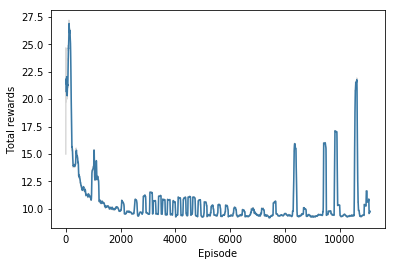

In [18]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

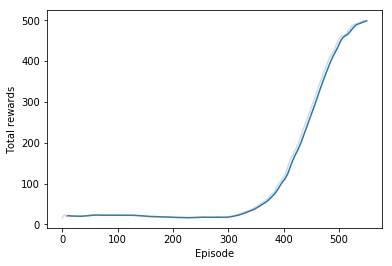

In [19]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

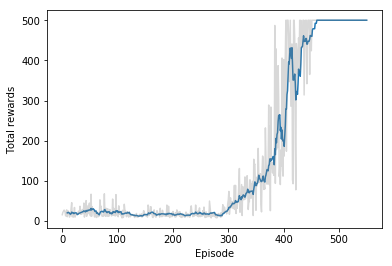

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

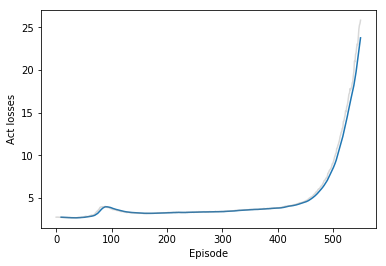

In [20]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

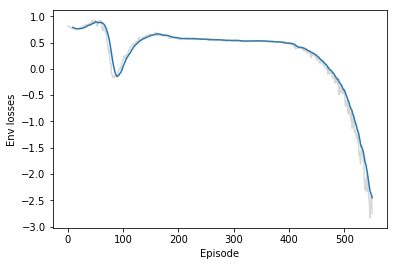

In [21]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
